# Modelo de predicción de abandono de clientes para la empresa Telecom

A continuación se muestra el analisis y creación de un modelo que predice si un cliente de la empresa Telecom es propenso a dejar el servicio en el futuro. Para este proyecto se emplearon varios datasets que contienen información de los contratos, planes adquiridos, servicios de internet y telefonia y datos personales. 
El desarrollo del proyecto se realiza en etapas de exploración y limpieza de datos, preprocesamiento, creación del modelo y optimización. Finalmente se creará un pipeline que permitirá procesar datos nuevos para realizar predicciones. Adicionalmente se incluye un análisis de curva lift para escoger aquellos clientes a los cuales se les pueden ofrecer ofertar para retener la compra de su producto.

El INFORME FINAL se encuentra en el úlitmo bloque del código.

## Plan de trabajo

Para afrontar esta tarea se pretende seguir el siguiente plan de trabajo:

1. Limpiar los datos.
   - Estandarizar los nombres de las columnas a letras minusculas.
   - Arreglar los tipos de datos según su respectiva categoría, los datos de fechas y datos numéricos que no están acordes.
   - No hay datos nulos pero si se observan datos columnas con espacios vacíos que se deben cambiar.
2. Adaptar los datos para el entrenamiento de los modelos.
   - Unir los dataframe en uno solo.
   - Realizar un análisis exploratorio de los datos.
   - Separar los datos en entrenamiento, validación y prueba.
   - Cambiar datos booleanos a numéricos y codificar características.
   - Realizar un balanceo de clases.
   - Crear nuevos dataframe basados en el balanceo de clases, sin balanceo, completos y con selección de características.
3. Entrenar los modelos.
   - Establecer las metricas de evaluación. Ya que es un problema de clasificación binario se calculara el F1 score que combina el recall y precision en una sola variable, el AUC-ROC ya que en este caso quiero aumentar la probabilidad de darle un bono a los clientes que tienen mayor posibilidad de irse (TPR) y reducir la tasa de clientes que probablemente no se vayan a ir pero les termino dando un bono (FPR).
   - Entrenar los modelos: Linear, Random Forest, Catboost, LGBM, XGBoost. Y probar su desempeño con las distintas metricas. Se seleccionan modelos que se basan en arboles de decisión y descenso del gradiente ya que tienen bastante eficiencia con datos de características binarias. 
4. Optimizar el modelo seleccionado.
   - Hacer selección de características usando Random Forest.
   - Optimizar el modelo que tenga un mejor desempeño usando GridSearch.
   - Basado en los resultados anteriores verificar con los datos de prueba el desempeño del modelo seleccionado.
   - Crear un pipeline de procesamiento de datos nuevos.
5. Informe final

## Librerias

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay, recall_score, precision_score
from xgboost import XGBClassifier
import catboost as catb
import lightgbm as lgbm
import joblib

In [2]:
# Definición del estado aleatorio para los modelos y generación de numeros aleatorios adicionales.
ran = 12345
random_seed = 42

## Revisión general de los datos

In [3]:
df_contract = pd.read_csv('final_provider/contract.csv')
df_internet = pd.read_csv('final_provider/internet.csv')
df_personal = pd.read_csv('final_provider/personal.csv')
df_phone = pd.read_csv('final_provider/phone.csv')

In [4]:
def revision_general(df):
    print(df.info())
    print()
    print(df.head())
    print()
    print(df.describe(include='all'))

In [5]:
revision_general(df_contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11

In [6]:
revision_general(df_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes

In [7]:
revision_general(df_personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

        customerID gender  SeniorCitizen Partner Dependents
count         7043   7043    7043.000000    7043       7043
unique        7043      2            NaN       2          2
top     7590-VHVEG

In [8]:
revision_general(df_phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390


Observaciones:

- El dataset de contract contiene información del inicio de contratación del servicio el tipo de contrato y los cargos que se han realizado por el uso del servicio.
- El dataset de internet contiene información de los usuarios que han pagado el uso de servicios de internet y sus subservicios como servicio tecnico, streaming de television y peliculas y pago de seguridad online.
- El dataset de personal contine información propiamente del cliente, su genero, si tiene pareja o personas que dependan de el o si es una persona de la tercer edad.
- El dataset de phone solo contiene información si el cliente tiene múltiples lineas.
- Ninguno de los datasets tiene datos nulos.
- Algunas variables como las fechas, datos booleanos y Total charges no se encuentran en sus tipos de datos correctos como tipo datetime o float.
- El total de usuarios es 7043 incluyendo los que adquieren servicios de television y los que adquieren servicio de internet.
- La columna customerID refleja el numero de identificación unico por cada usuario.

## Análisis exploratorio

In [9]:
print(f"""
      Datos duplicados:
      df phone: {df_phone.duplicated().sum()}
      df contract: {df_contract.duplicated().sum()}
      df internet: {df_internet.duplicated().sum()}
      df phone: {df_phone.duplicated().sum()}
      """)


      Datos duplicados:
      df phone: 0
      df contract: 0
      df internet: 0
      df phone: 0
      


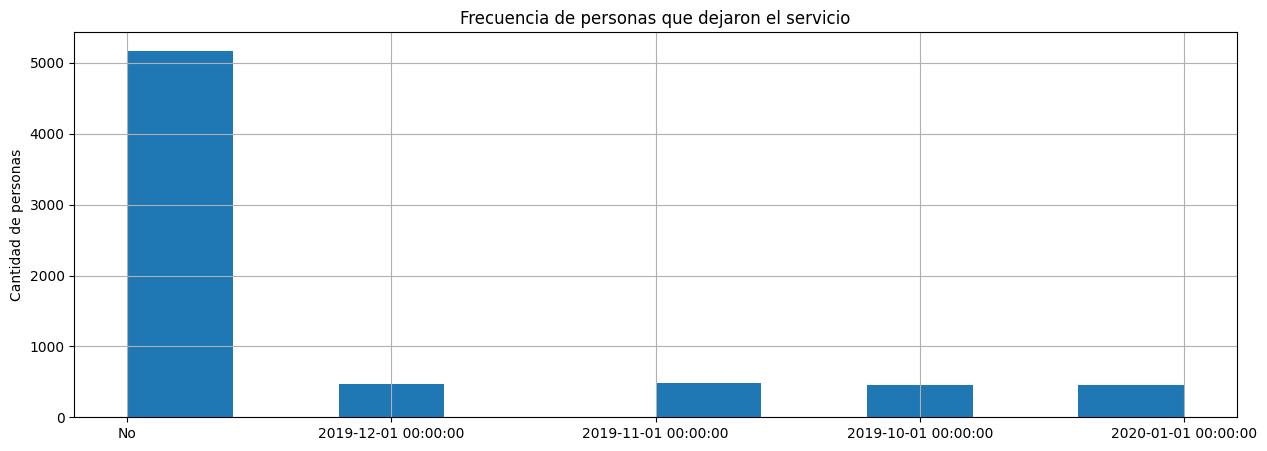

In [10]:
fig, ax = plt.subplots(figsize=(15,5))
df_contract['EndDate'].hist()
plt.title('Frecuencia de personas que dejaron el servicio')
plt.ylabel('Cantidad de personas')
plt.show()

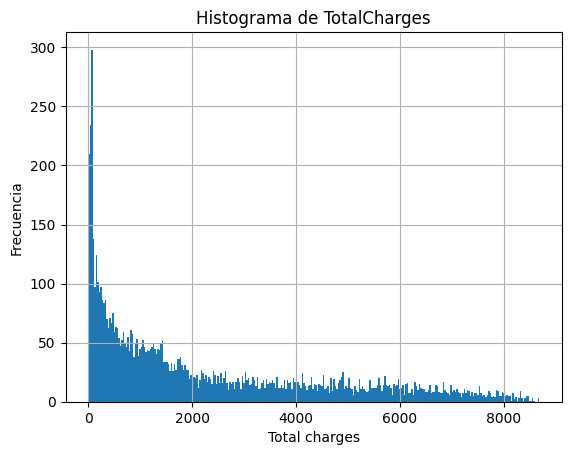

In [11]:
df_contract_c = df_contract.copy()
df_contract_c['TotalCharges'] = df_contract_c['TotalCharges'].replace(' ', 0).astype(float)
df_contract_c['TotalCharges'].sort_values(ascending=True).hist(bins=300)
plt.xlabel('Total charges')
plt.ylabel('Frecuencia')
plt.title('Histograma de TotalCharges')
plt.show()

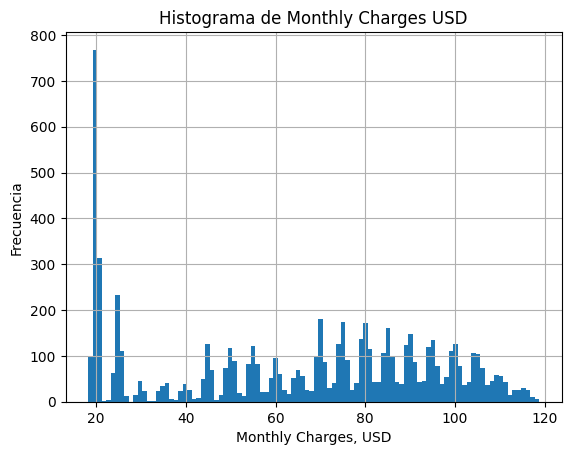

In [12]:
df_contract_c['MonthlyCharges'].sort_values(ascending=True).hist(bins=100)
plt.xlabel('Monthly Charges, USD')
plt.ylabel('Frecuencia')
plt.title('Histograma de Monthly Charges USD')
plt.show()

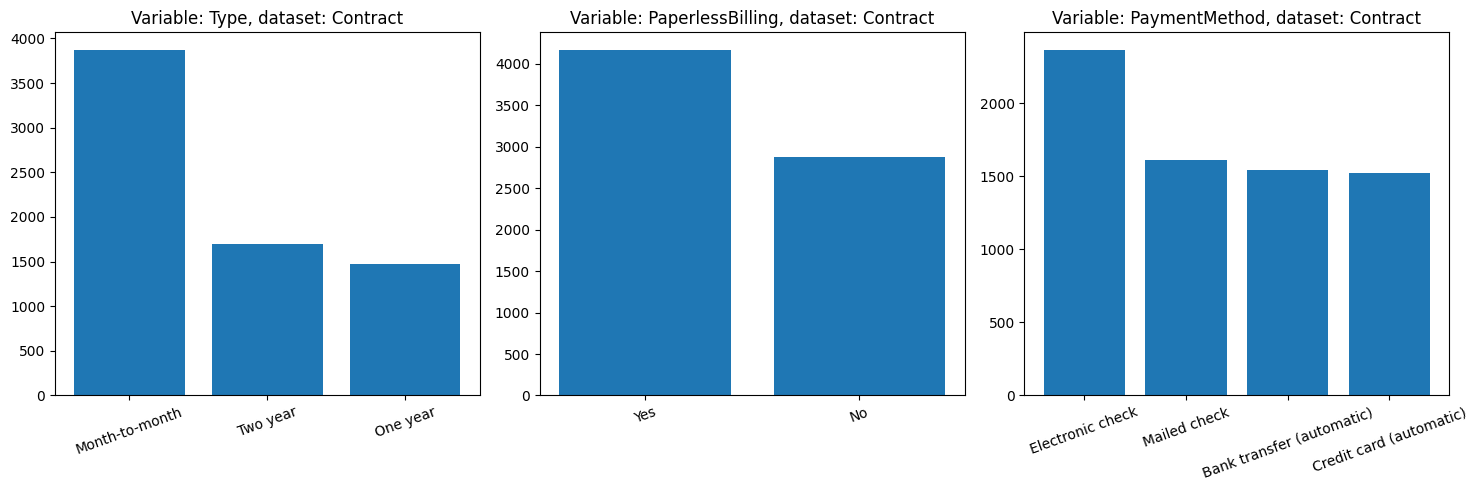

In [13]:
columnas_contract_bar = [ 'Type', 'PaperlessBilling', 'PaymentMethod']
fig, axs = plt.subplots(1, 3,figsize=(15,5))
for i,columna in enumerate(columnas_contract_bar):
    valores = df_contract_c[columna].value_counts()
    axs[i].bar(valores.index, valores.values)
    axs[i].set_title(f'Variable: {columna}, dataset: {'Contract'}')
    axs[i].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

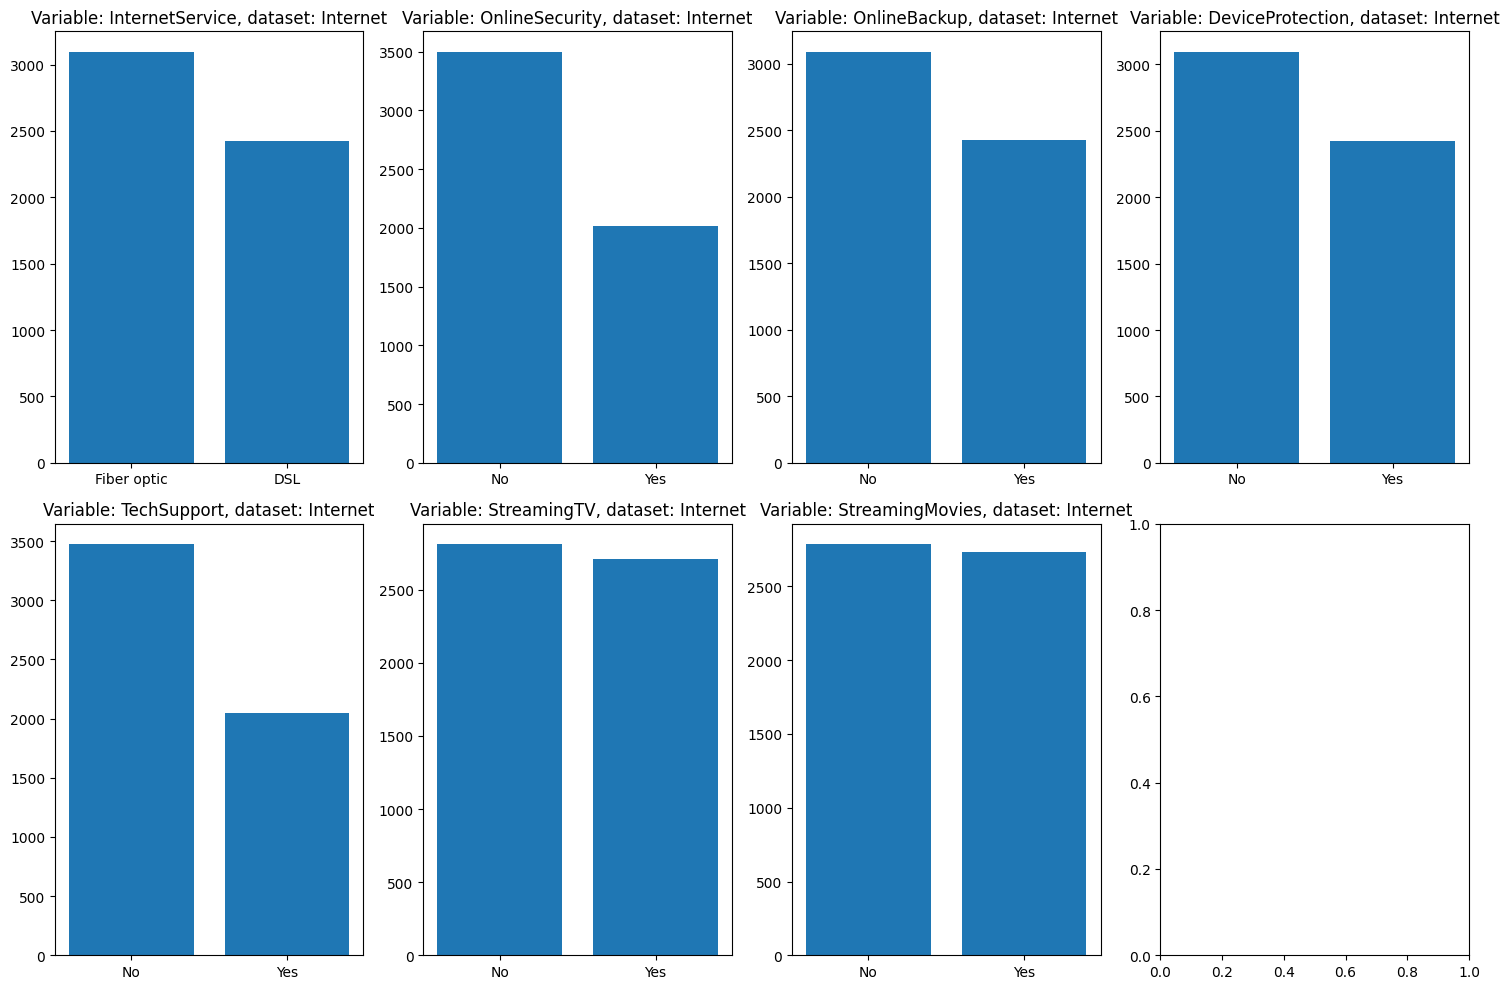

In [14]:
columnas_internet_bar = ['InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
fig, axs = plt.subplots(2,4,figsize=(15,10))
axs =axs.flatten()
for i,columna in enumerate(columnas_internet_bar):
    valores = df_internet[columna].value_counts()
    axs[i].bar(valores.index, valores.values)
    axs[i].set_title(f'Variable: {columna}, dataset: {'Internet'}')

plt.tight_layout()
plt.show()

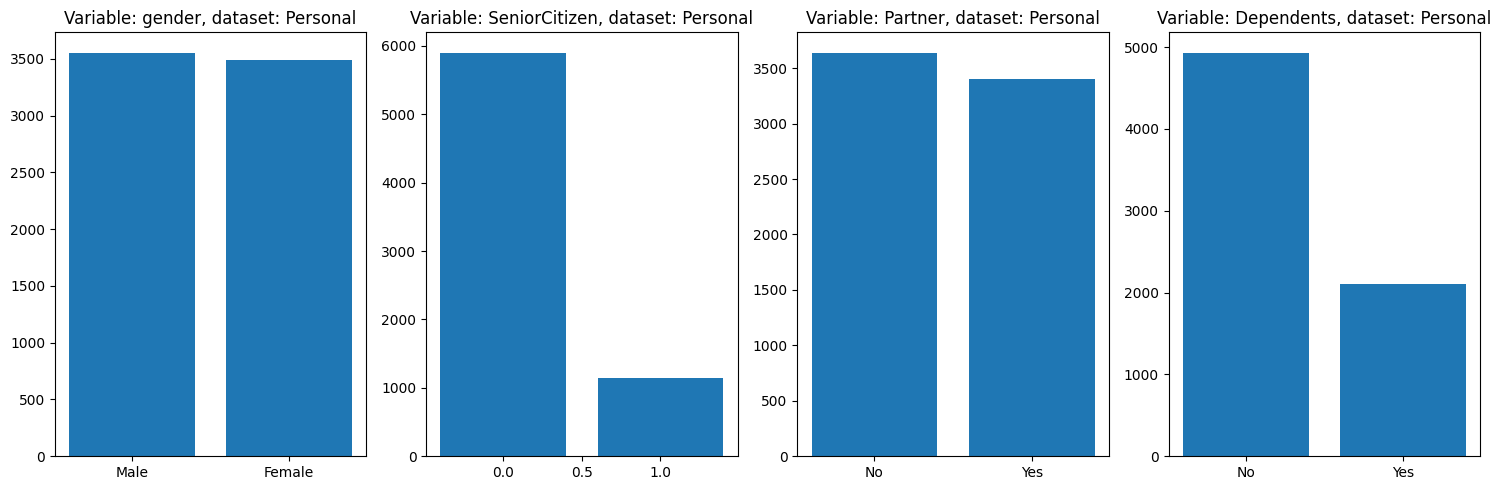

In [15]:
columnas_personal_bar = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
fig, axs = plt.subplots(1,4,figsize=(15,5))
for i,columna in enumerate(columnas_personal_bar):
    valores = df_personal[columna].value_counts()
    axs[i].bar(valores.index, valores.values)
    axs[i].set_title(f'Variable: {columna}, dataset: {'Personal'}')

plt.tight_layout()
plt.show()

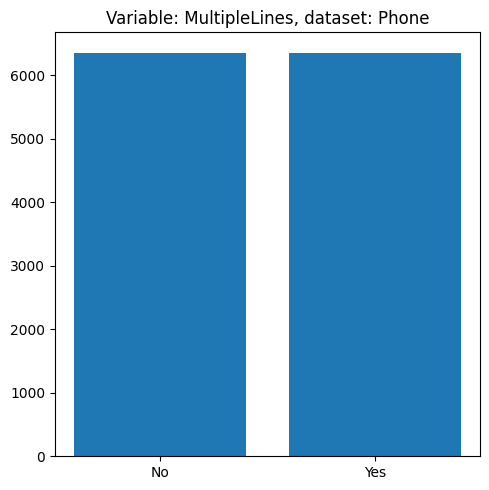

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(df_phone['MultipleLines'].values, df_phone['MultipleLines'].index)
ax.set_title(f'Variable: MultipleLines, dataset: Phone')

plt.tight_layout()
plt.show()

Observaciones:

- La variable target, que es EndDate, está desbalanceada.
- La mayoría de las variables son categóricas.
- Las únicas variables numéricas son la fecha y los costos totales de pago.
- Solo hay 4 fechas relacionadas a la salida de clientes.
- Un alto número de clientes pagan alrededor de 20 dolares, el resto se encuentra mayormente distribuido alrededor de los 80 dolares.
- Existe predominancia por el pago mes a mes, así como no recibir la cuenta en papel y además realizar pagos por cheque electrónico.
- Variables como streamingTV y streamingMovies se encuentran balanceadas y tienen casi la misma cantidad de cliente que usan y no usan el servicio, entre los que usan servicio de internet.
- Existe igualdad de clientes hombres y mujeres. En su mayoría los clientes no son de la tercera edad. 
- No todos los clientes tienen contratados servicios de internet y no todos los clientes tienen contratado servicio de telefono.

## Preprocesamiento de los datos

### Estandarizar los nombres de las columnas

- Se realiza un ajuste de los nombres de las columnas a letra minúscula para facilitar su tratamiento posterior.

In [17]:
df_contract_m = df_contract.copy()
df_internet_m = df_internet.copy()
df_personal_m = df_personal.copy()
df_phone_m = df_phone.copy()

In [18]:
def column_name_to_lowercase(df):
    return df.columns.str.lower()

In [19]:
df_contract_m.columns = column_name_to_lowercase(df_contract_m)
df_internet_m.columns = column_name_to_lowercase(df_internet_m)
df_personal_m.columns = column_name_to_lowercase(df_personal_m)
df_phone_m.columns = column_name_to_lowercase(df_phone_m)

### Cambio de tipo de datos

#### Dataframe contract

- Se realizan cambios de formato sobre begindat, enddate y totalcharges

In [20]:
# Cambio a formato fecha begindate
df_contract_m['begindate'] = pd.to_datetime(df_contract_m['begindate'], format='%Y-%m-%d')

In [21]:
df_contract_m.rename(columns={'enddate': 'chrun'}, inplace=True)

In [22]:
# Función que transforma los valores de la columna enddate a binario: 1 para fecha, 0 para No
def end_date_format(value):
    value = value.strip()
    if value == 'No':
        return 0
    else:
        return 1
df_contract_m['chrun'] = df_contract_m['chrun'].apply(end_date_format)

In [23]:
# Cambio de los tipos de dato de totalcharges a float y llenado de espacios vacios
df_contract_m['totalcharges'] = df_contract_m['totalcharges'].replace(' ', 0).astype(float)

In [24]:
# Se adiciona la columna months, con base en la cantidad de meses aproximada que la persona ha tenido el servicio
df_contract_m['months'] = round(df_contract_m['totalcharges']/df_contract_m['monthlycharges'],0)

- El cálculo de meses aproximados que la persona ha usado el servicio se emplea usando el pago total en totalcharges y se divide por el pago mensual. 

#### Dataframe internet

- No se realiza cambio de formato sobre ninguna de las columnas y no se observan strings como espacios para reemplazar.

In [25]:
for column in df_internet_m.columns:
    print(f' Columna: {column}: {df_internet_m[column].unique()}')

 Columna: customerid: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
 Columna: internetservice: ['DSL' 'Fiber optic']
 Columna: onlinesecurity: ['No' 'Yes']
 Columna: onlinebackup: ['Yes' 'No']
 Columna: deviceprotection: ['No' 'Yes']
 Columna: techsupport: ['No' 'Yes']
 Columna: streamingtv: ['No' 'Yes']
 Columna: streamingmovies: ['No' 'Yes']


#### Dataframe personal

- No se realiza cambio de formato sobre ninguna de las columnas y no se observan strings como espacios para reemplazar.

In [26]:
for column in df_personal_m.columns:
    print(f' Columna: {column}: {df_personal_m[column].unique()}')

 Columna: customerid: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
 Columna: gender: ['Female' 'Male']
 Columna: seniorcitizen: [0 1]
 Columna: partner: ['Yes' 'No']
 Columna: dependents: ['No' 'Yes']


#### Dataframe phone

- No se realiza cambio de formato sobre ninguna de las columnas y no se observan strings como espacios para reemplazar.

In [27]:
for column in df_phone_m.columns:
    print(f' Columna: {column}: {df_phone_m[column].unique()}')

 Columna: customerid: ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
 Columna: multiplelines: ['No' 'Yes']


### Combinación de los dataframes

- Hay clientes que no contrataron ningun servicio de internet o bien no contrataron servicio de telefono por lo que igualmente si no contrataron estos servicios su valor en la columna será 0

In [28]:
df_merge = df_contract_m.merge(df_internet_m, on='customerid', how='outer')\
                        .merge(df_personal_m, on='customerid', how='outer')\
                        .merge(df_phone_m, on='customerid', how='outer')

In [29]:
# Aquellos que no contrataron un servicio de internet se clasifican como not hired.
df_merge_m = df_merge.copy()
df_merge_m['internetservice'] = df_merge_m['internetservice'].fillna('Not Hired')

In [30]:
df_merge_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   chrun             7043 non-null   int64         
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   months            7043 non-null   float64       
 9   internetservice   7043 non-null   object        
 10  onlinesecurity    5517 non-null   object        
 11  onlinebackup      5517 non-null   object        
 12  deviceprotection  5517 non-null   object        
 13  techsupport       5517 non-null   object        
 14  streamingtv       5517 n

In [31]:
dict_yes_no = {
    'Yes' : 1,
    'No' : 0,
 }

In [32]:
yes_no_columns = ['paperlessbilling', 'onlinesecurity', 'onlinebackup','deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'partner', 'dependents', 'multiplelines']
for col in yes_no_columns:
    df_merge_m[col] = df_merge_m[col].map(dict_yes_no)

In [33]:
for column in yes_no_columns:
    print(f' Columna: {column}: {df_merge_m[column].unique()}')

 Columna: paperlessbilling: [1 0]
 Columna: onlinesecurity: [ 0.  1. nan]
 Columna: onlinebackup: [ 1.  0. nan]
 Columna: deviceprotection: [ 0.  1. nan]
 Columna: techsupport: [ 1.  0. nan]
 Columna: streamingtv: [ 1.  0. nan]
 Columna: streamingmovies: [ 0.  1. nan]
 Columna: partner: [1 0]
 Columna: dependents: [1 0]
 Columna: multiplelines: [ 0.  1. nan]


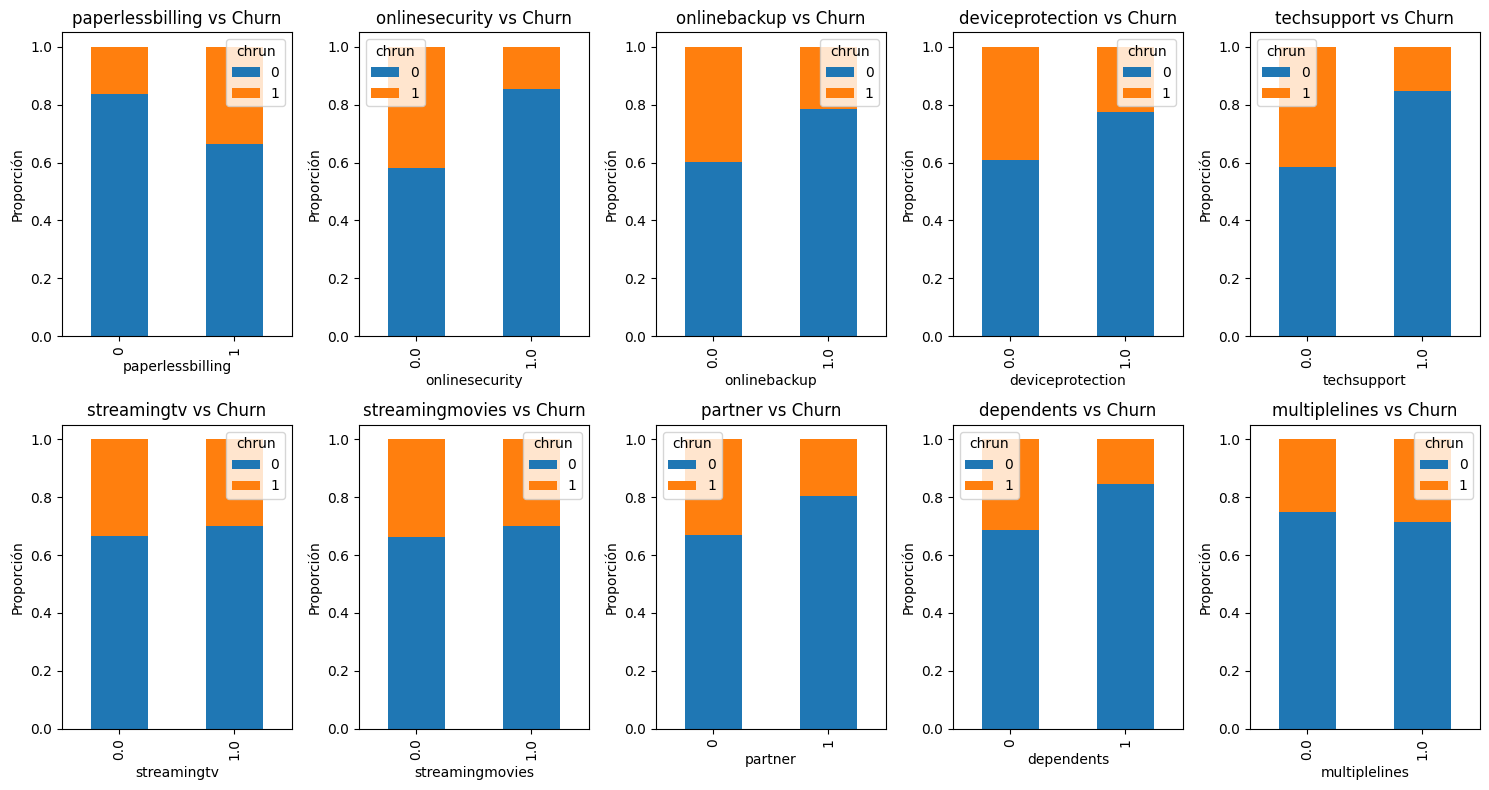

In [34]:
fig, axs = plt.subplots(2,5,figsize=(15,8))
axs= axs.flatten()
for i,col in enumerate(yes_no_columns):
    ct = pd.crosstab(df_merge_m[col], 
                     df_merge_m['chrun'], 
                     normalize='index'
                     )
    ct.plot(kind='bar', stacked=True, ax =axs[i])
    axs[i].set_title(f'{col} vs Churn')
    axs[i].set_ylabel('Proporción')
plt.tight_layout()
plt.show()

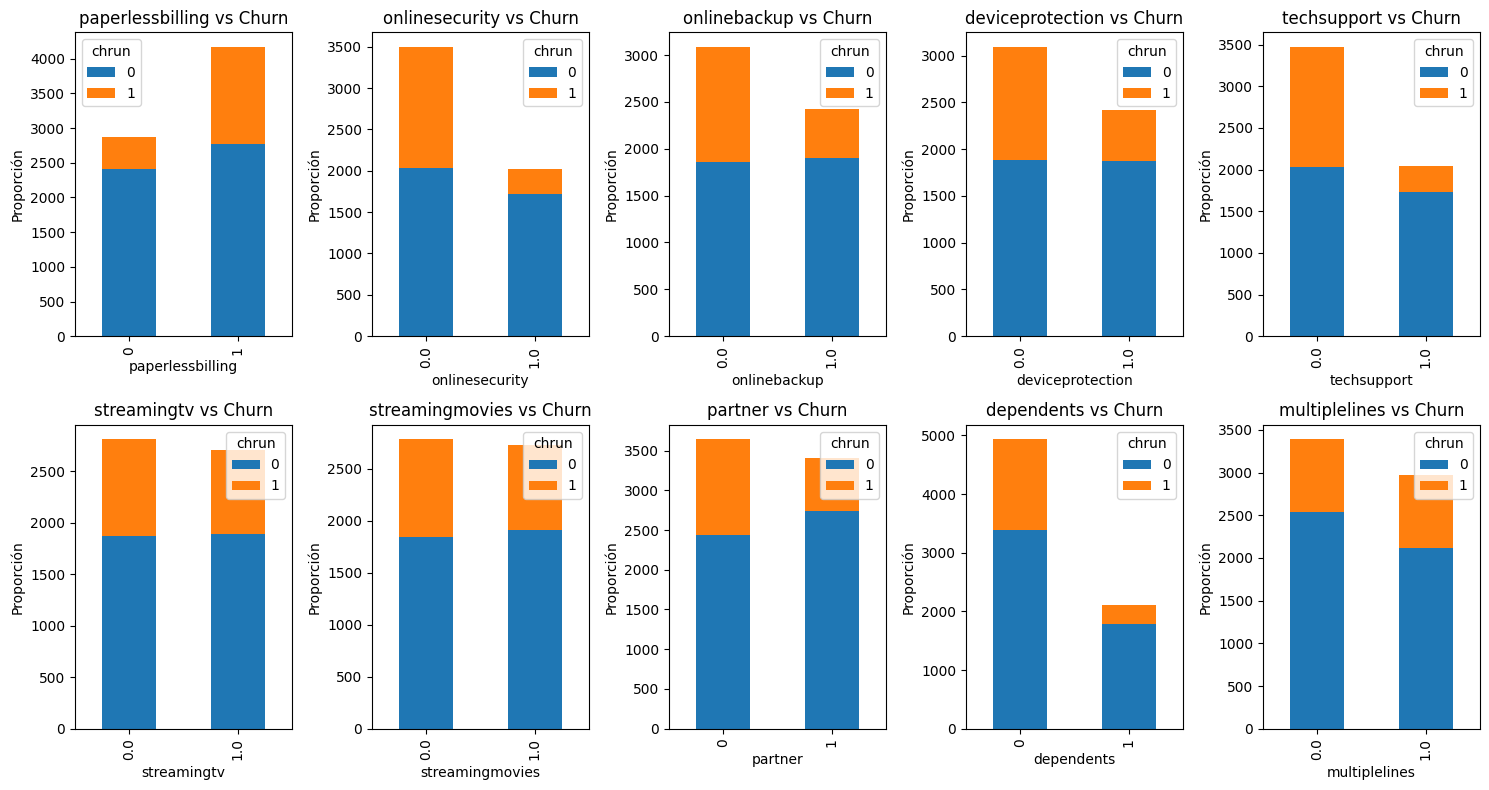

In [35]:
fig, axs = plt.subplots(2,5,figsize=(15,8))
axs= axs.flatten()
for i,col in enumerate(yes_no_columns):
    ct = pd.crosstab(df_merge_m[col], 
                     df_merge_m['chrun'], 
                    #  normalize='index'
                     )
    ct.plot(kind='bar', stacked=True, ax =axs[i])
    axs[i].set_title(f'{col} vs Churn')
    axs[i].set_ylabel('Proporción')
plt.tight_layout()
plt.show()

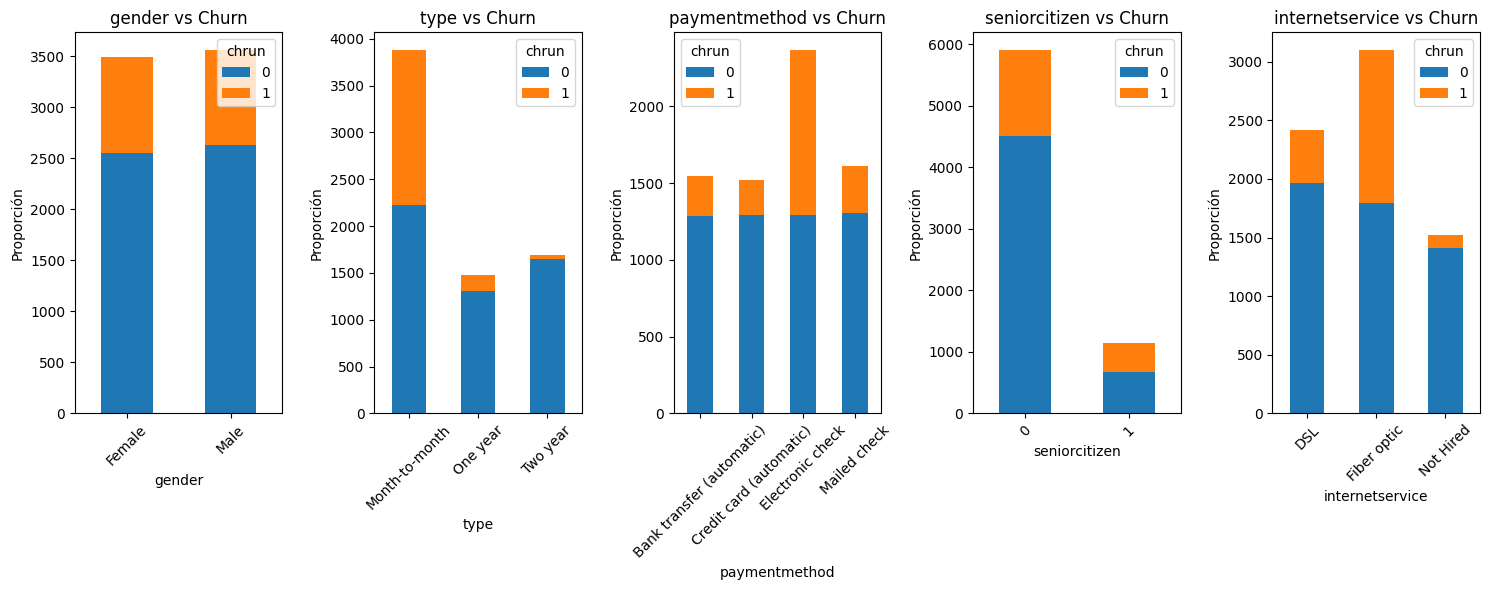

In [36]:
others_cross = ['gender', 'type', 'paymentmethod', 'seniorcitizen', 'internetservice']
fig, axs = plt.subplots(1,5,figsize=(15,6))
axs= axs.flatten()
for i,col in enumerate(others_cross):
    ct = pd.crosstab(df_merge_m[col], 
                     df_merge_m['chrun'], 
                    #  normalize='index'
                     )
    ct.plot(kind='bar', stacked=True, ax =axs[i])
    axs[i].set_title(f'{col} vs Churn')
    axs[i].set_ylabel('Proporción')
    axs[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

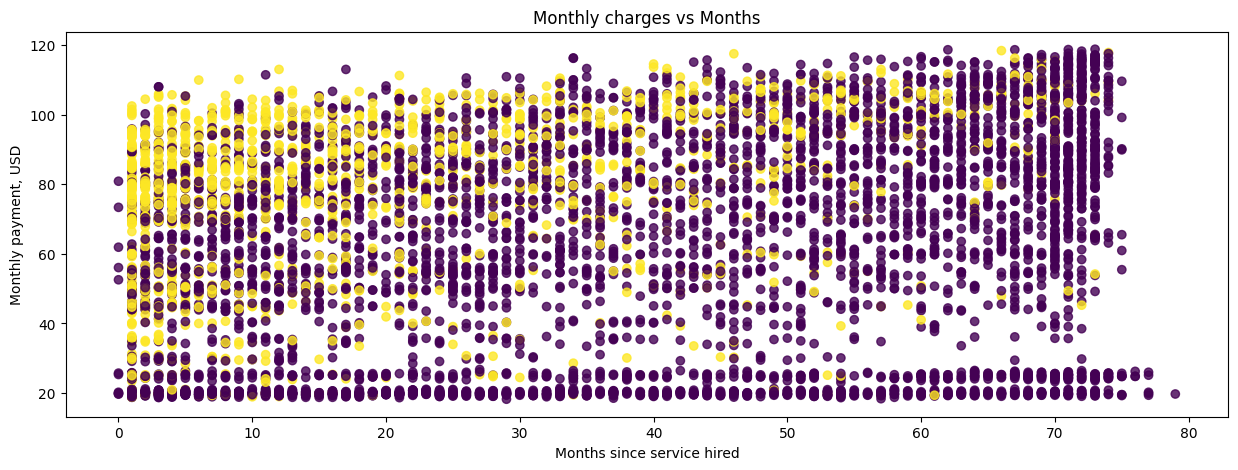

In [37]:
fig, axs = plt.subplots(figsize=(15,5))
plt.scatter(df_merge_m['months'], df_merge_m['monthlycharges'], c=df_merge_m['chrun'], alpha=0.8)
plt.title('Monthly charges vs Months')
plt.xlabel('Months since service hired')
plt.ylabel('Monthly payment, USD')
plt.show()

In [38]:
df_merge_m['monthlycharges_gouped'] = pd.qcut(df_merge_m['monthlycharges'], q=50)

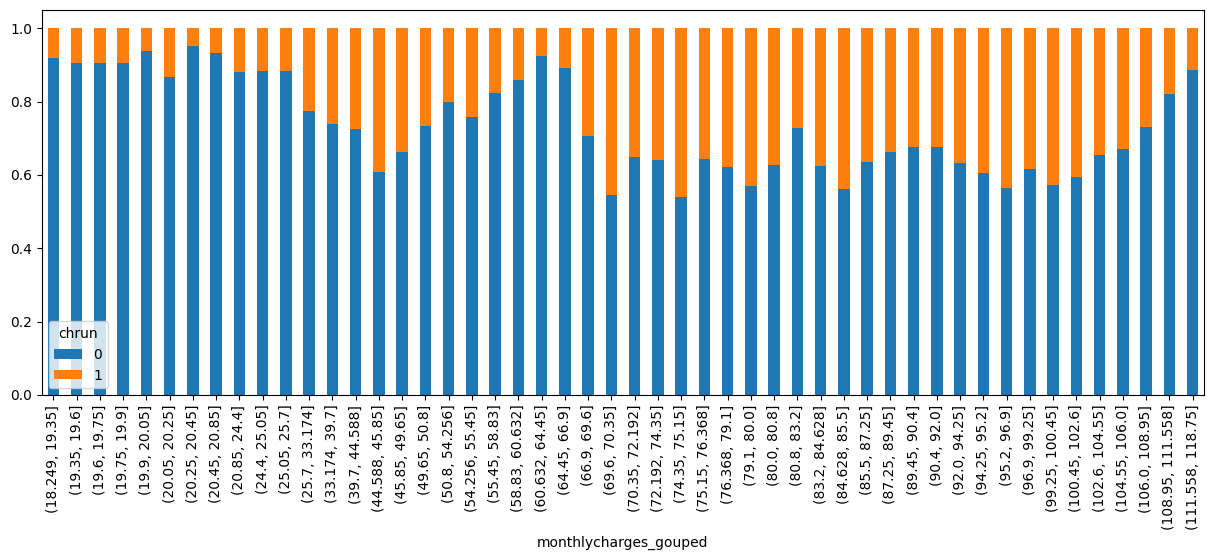

In [39]:
fig, axs = plt.subplots(figsize=(15,5))
new_ct = pd.crosstab(df_merge_m['monthlycharges_gouped'], 
                     df_merge_m['chrun'], 
                    normalize='index'
                     )
new_ct.plot(kind='bar', stacked=True, ax=axs)
plt.show()

- Variables como multiple lines, streamingtv y streaming movies no presentan mucha información de la variable objetivo pues también en porcentajes tienen número similares en porcentaje de personas que han abandonado el servicio. 
- Variables como el paymentmethod y type visiblemente aportan más información pues los números de personas que dejan el servicio son visiblemente mayores.
- Este análisis muestra que posiblemente se puede reducir la dimensionalidad del problema eliminando algunas columnas para aligerar los modelos.
- El análisis de meses y abandono muestra que las personas que han tenido el servicio por un mayor tiempo son más propensos a abandonar el servicio.
- No se observan variables que tengan una alta relevancia a simple vista, sin embargo, si se puede observar que varibales como el tipo de pago mes a mes y el metodo de pago electronic check tienden a tener más usuarios que dejan el servicio.
- Al agrupar los datos de pago y graficarlos contra la tasa de deserción, los usuarios con pagos más altos tienden a dejar más el servicio que aquellos con pagos bajos. 

### Separación de los dataframes de entrenamiento, validación y prueba

In [40]:
df_train, df_pass = train_test_split(df_merge_m, test_size=0.30, random_state=ran, stratify=df_merge_m['chrun'])
df_valid, df_test = train_test_split(df_pass, test_size=0.5, random_state=ran, stratify=df_pass['chrun'])

In [41]:
def fix_df_traintest(df):
    df = df.reset_index(drop=True).drop(['customerid', 'begindate', 'monthlycharges_gouped'], axis=1)
    return df

In [42]:
df_train = fix_df_traintest(df_train)
df_valid = fix_df_traintest(df_valid)
df_test = fix_df_traintest(df_test)

- Debido a la poca cantidad de datos se usa un tamaño de datos de validación y teste de 15% cada uno.
- Las variables begindate y monthylcharges_grouped no se usan para el análisis puesto que su valor está intrinsecamente dentro de la variable monthly.
- La variable customerid no presenta información para el análisis.

### Codificación de variables categóricas

- Las pruebas de los modelos se realizarán con los siguientes modificaciones:
  - Codificación ordinal de las variables categóricas,
  - Codificación OHE de las variables categóricas,
  - Escalado de datos numéricos.
  - Haciendo un sobremuestreo con bootstraping,
  - Reemplazo de datos nulos.

- Se realizarán combianaciones de las modificaciones anteriores para encontrar la mejor combinación.

#### Codificación ordinal

In [43]:
categorical_variables = ['type', 'paymentmethod', 'internetservice', 'gender']
categorical_encoder = OrdinalEncoder()
categorical_encoder.fit(df_train[categorical_variables])

def ordinal_encoder(df, encoder=categorical_encoder):
    var_encoded = pd.DataFrame(encoder.transform(df[categorical_variables]), 
                                columns=df[categorical_variables].columns)
    return pd.concat([df.drop(categorical_variables, axis=1), var_encoded], axis=1)

In [44]:
df_train_ord_encoded_null =ordinal_encoder(df_train)
df_valid_ord_encoded_null = ordinal_encoder(df_valid)

In [45]:
encoder_info = {
    'encoder': categorical_encoder,
    'columns': df_train[categorical_variables].columns.tolist()
}
joblib.dump(encoder_info, 'pretrained_models/ordinal_encoder_with_columns.pkl')

['pretrained_models/ordinal_encoder_with_columns.pkl']

#### One hot encoding

In [46]:
def ohe_encoding(df):
    ohe_var_encoded = pd.get_dummies(df[categorical_variables], drop_first=True, dtype=float)
    return pd.concat([df.drop(categorical_variables, axis=1), ohe_var_encoded], axis=1).reset_index(drop=True)

In [47]:
df_train_ohe_null = ohe_encoding(df_train)
df_valid_ohe_null = ohe_encoding(df_valid)

### Escalado de variables numéricas

In [48]:
scaler = StandardScaler()
numerical_variables = ['monthlycharges', 'totalcharges', 'months']
scaler.fit(df_train[numerical_variables])  

def numerical_scaler(df, scaler=scaler):
    numerical_scaled = pd.DataFrame(scaler.transform(df[numerical_variables]), columns=numerical_variables)
    return pd.concat([df.drop(numerical_variables, axis=1), numerical_scaled], axis=1)  

In [49]:
df_train_ord_encoded_null_scaled = numerical_scaler(df_train_ord_encoded_null)
df_train_ohe_null_scaled = numerical_scaler(df_train_ohe_null)
df_valid_ord_encoded_null_scaled = numerical_scaler(df_valid_ord_encoded_null)
df_valid_ohe_null_scaled= numerical_scaler(df_valid_ohe_null)

### Llenado de valores nulos

- Los valores nulos se reemplazan por 0 puesto que se asume que la persona no adquirió el servicio.

In [50]:
df_train_ord_encoded_notnull = df_train_ord_encoded_null.fillna(0)
df_train_ohe_notnull = df_train_ohe_null.fillna(0)
df_train_ord_encoded_notnull_scaled = df_train_ord_encoded_null_scaled.fillna(0)
df_train_ohe_notnull_scaled = df_train_ohe_null_scaled.fillna(0)

In [51]:
df_valid_ord_encoded_notnull = df_valid_ord_encoded_null.fillna(0)
df_valid_ohe_notnull = df_valid_ohe_null.fillna(0)
df_valid_ord_encoded_notnull_scaled = df_valid_ord_encoded_null_scaled.fillna(0)
df_valid_ohe_notnull_scaled = df_valid_ohe_null_scaled.fillna(0)

### Balanceo de clases

In [52]:
def upsampling_dataframe(df, bootstrap = True, repeat=2):
    np.random.seed(random_seed)
    boostrap_data = []
    positive_df = df[df['chrun']==1]
    negative_df = df[df['chrun']==0]
    if bootstrap == True:    
        for i in range(len(positive_df)-1):
            random_index = np.random.randint(0, len(positive_df)-1)
            boostrap_data.append(positive_df.iloc[random_index,:])
        boostrap_data = pd.DataFrame(boostrap_data, columns=positive_df.columns)
        bootstrap_df = pd.concat([positive_df, boostrap_data, negative_df], axis=0)
        bootstrap_df_shuffle = shuffle(bootstrap_df, random_state=ran )
        return bootstrap_df_shuffle
    else:
        df_upsample = pd.concat([negative_df]+[positive_df]*repeat)
        df_shuffled = shuffle(df_upsample, random_state=ran )
        return df_shuffled


In [53]:
df_train_ord_encoded_notnull_up = upsampling_dataframe(df_train_ord_encoded_notnull)
df_train_ohe_notnull_up = upsampling_dataframe(df_train_ohe_notnull)
df_train_ord_encoded_notnull_scaled_up = upsampling_dataframe(df_train_ord_encoded_notnull_scaled)
df_train_ohe_notnull_scaled_up = upsampling_dataframe(df_train_ohe_notnull_scaled)

### Separación de features y target

In [54]:
def features_target_split(df):
    features = df.drop(['chrun'], axis=1)
    target = df['chrun']
    return features, target

## Entrenamiento de modelos

In [55]:
# Esta función toma las predicciones y la variable objetivo y genera los valores de las metricas de evaluación
def metrics_results(model_name, target, predictions, predictions_proba, show_print =False):
    recall = recall_score(target, predictions)
    precision = precision_score(target, predictions)
    cm = confusion_matrix(target, predictions)
    f1_scr = f1_score(target, predictions)
    roc_auc_scr = roc_auc_score(target, predictions)
    roc_curve_result = roc_curve(target, predictions_proba[:,1])
    pr_curve_result = precision_recall_curve(target,predictions_proba[:,1])
    
    if show_print == True:
      print(f"""
            Modelo: {model_name}
            F1 score: {f1_scr:.2f}
            ROC AUC score: {roc_auc_scr:.2f}
            Recall: {recall:.2f}
            Precision: {precision:.2f}""")
    
    return cm, f1_scr, roc_auc_scr, roc_curve_result, pr_curve_result

In [56]:
# Esta función solo formatea el f1 score y el roc auc para poder tabularse posteriormente
def format_simple_results(metrics_results):
    cm, f1_scr, roc_auc_scr, roc_curve_result, pr_curve_result = metrics_results
    return [np.round(f1_scr,2), np.round(roc_auc_scr,2)]

In [57]:
# Esta función grafica la curva roc, la matriz de confusión y la curva pr.
def metrics_graphs(model, model_name, metrics_results):
    cm, f1_scr, roc_auc_scr, roc_curve_result, pr_curve_result = metrics_results
    precision, recall, _ = pr_curve_result
    
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp_pr = PrecisionRecallDisplay(precision=precision,recall= recall)
    fpr, tpr, threshold = roc_curve_result
    disp_cm.plot(ax=axs[0])
    axs[0].set_title('Matriz de confusión')
    axs[1].scatter(fpr, tpr)
    axs[1].set_title('Curva ROC')
    axs[1].set_xlabel('FPR')
    axs[1].set_ylabel('TPR')
    axs[1].grid(True)
    disp_pr.plot(ax=axs[2])
    axs[2].set_title('Curva Precision-Recall')
    plt.suptitle(f'Evaluación del Modelo {model_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    # plt.tight_layout()
    plt.show()

In [58]:
# Esta función toma un modelo, lo entrena y genera las metricas de entrenamiento y validación
def model_evaluation_meth(model, model_name, df_train, df_valid, show_print = False, graph=False):
    features_t, target_t = features_target_split(df_train)
    features_v, target_v = features_target_split(df_valid)
    model.fit(features_t, target_t)
    predictions_t = model.predict(features_t)
    predictions_v = model.predict(features_v)
    predictions_proba_t = model.predict_proba(features_t)
    predictions_proba_v = model.predict_proba(features_v)
    
    metrics_resuts_train = metrics_results(model_name + ' - Entrenamiento', target_t, predictions_t, predictions_proba_t, show_print)
    metrics_results_valid = metrics_results(model_name + ' - Validacion', target_v, predictions_v, predictions_proba_v, show_print)
        
    if graph == True:
        metrics_graphs(model, model_name + ' - Entrenamiento', metrics_resuts_train)
        metrics_graphs(model, model_name + ' - Validacion', metrics_results_valid)
    
    if show_print == False:
        f1_scr_t, roc_auc_scr_t = format_simple_results(metrics_resuts_train)
        f1_scr_v, roc_auc_scr_v = format_simple_results(metrics_results_valid)
        return [f1_scr_t, roc_auc_scr_t, f1_scr_v, roc_auc_scr_v]
    else:
        print('         ****')


In [59]:
# Esta función toma un modelo y lo evalua con distintos dataframes.
def multiple_model_evaluation(model, model_name, ord_enc=True, ohe=True, upsampling=True, scaled_upsampling=True):
    results = []
    indexs = []
    if ord_enc == True:
        results.append(model_evaluation_meth(model, 
                            f'{model_name} - Ordinal encoding / Sin Escalado / Sin Upsampling',
                            df_train_ord_encoded_notnull, 
                            df_valid_ord_encoded_notnull))
        indexs.append('Ordinal encoding / Sin Escalado / Sin Upsampling')
    if ord_enc == True & upsampling == True:
        results.append(model_evaluation_meth(model, 
                            f'{model_name} - Ordinal encoding / Sin Escalado / Con Upsampling',
                            df_train_ord_encoded_notnull_up, 
                            df_valid_ord_encoded_notnull))
        indexs.append('Ordinal encoding / Sin Escalado / Con Upsampling')
    if ord_enc == True & scaled_upsampling == True:
        results.append(model_evaluation_meth(model, 
                            f'{model_name} - Ordinal encoding / Con Escalado / Con Upsampling',
                            df_train_ord_encoded_notnull_scaled_up, 
                            df_valid_ord_encoded_notnull_scaled))
        indexs.append('Ordinal encoding / Con Escalado / Con Upsampling')
    if ohe == True:
        results.append(model_evaluation_meth(model, 
                            f'{model_name} - OHE / Sin Escalado / Sin Upsampling',
                            df_train_ohe_notnull, 
                            df_valid_ohe_notnull))
        indexs.append('OHE / Sin Escalado / Sin Upsampling')
    if ohe == True & upsampling == True:
        results.append(model_evaluation_meth(model, 
                            f'{model_name} - OHE / Sin Escalado / Con Upsampling',
                            df_train_ohe_notnull_up, 
                            df_valid_ohe_notnull))
        indexs.append('OHE / Sin Escalado / Con Upsampling')
    if ohe == True & scaled_upsampling == True:
        results.append(model_evaluation_meth(model, 
                            f'{model_name} - OHE / Con Escalado / Con Upsampling',
                            df_train_ohe_notnull_scaled_up, 
                            df_valid_ohe_notnull_scaled))
        indexs.append('OHE / Con Escalado / Con Upsampling')
    df_results = pd.DataFrame(results,index=indexs, columns=['f1_scr_t', 'roc_auc_scr_t', 'f1_scr_v', 'roc_auc_scr_v'])
    print(df_results)

#### Regresion logistica

In [60]:
model_logistic_regression = LogisticRegression(random_state=ran, solver='liblinear')

In [61]:
multiple_model_evaluation(model_logistic_regression,
                          'Regresión Logística',
                          ord_enc=True, 
                          ohe=True, 
                          upsampling=True, 
                          scaled_upsampling=True)

                                                  f1_scr_t  roc_auc_scr_t  \
Ordinal encoding / Sin Escalado / Sin Upsampling      0.59           0.71   
Ordinal encoding / Sin Escalado / Con Upsampling      0.72           0.75   
Ordinal encoding / Con Escalado / Con Upsampling      0.72           0.75   
OHE / Sin Escalado / Sin Upsampling                   0.59           0.72   
OHE / Sin Escalado / Con Upsampling                   0.72           0.76   
OHE / Con Escalado / Con Upsampling                   0.72           0.76   

                                                  f1_scr_v  roc_auc_scr_v  
Ordinal encoding / Sin Escalado / Sin Upsampling      0.62           0.74  
Ordinal encoding / Sin Escalado / Con Upsampling      0.64           0.78  
Ordinal encoding / Con Escalado / Con Upsampling      0.64           0.78  
OHE / Sin Escalado / Sin Upsampling                   0.61           0.73  
OHE / Sin Escalado / Con Upsampling                   0.65           0.77  
OHE 

#### Random Forest Classifier

In [62]:
model_random_forest = RandomForestClassifier(n_estimators=100, 
                                             criterion='gini',
                                             max_depth=8,
                                             random_state=ran,
                                             )

In [63]:
multiple_model_evaluation(model_random_forest,
                          'Random Forest',
                          ord_enc=True, 
                          ohe=True, 
                          upsampling=True, 
                          scaled_upsampling=True)

                                                  f1_scr_t  roc_auc_scr_t  \
Ordinal encoding / Sin Escalado / Sin Upsampling      0.66           0.76   
Ordinal encoding / Sin Escalado / Con Upsampling      0.81           0.83   
Ordinal encoding / Con Escalado / Con Upsampling      0.81           0.84   
OHE / Sin Escalado / Sin Upsampling                   0.63           0.74   
OHE / Sin Escalado / Con Upsampling                   0.80           0.83   
OHE / Con Escalado / Con Upsampling                   0.80           0.83   

                                                  f1_scr_v  roc_auc_scr_v  
Ordinal encoding / Sin Escalado / Sin Upsampling      0.59           0.72  
Ordinal encoding / Sin Escalado / Con Upsampling      0.64           0.77  
Ordinal encoding / Con Escalado / Con Upsampling      0.65           0.77  
OHE / Sin Escalado / Sin Upsampling                   0.60           0.72  
OHE / Sin Escalado / Con Upsampling                   0.66           0.78  
OHE 

#### XGBOOST

In [64]:
model_xgboost = XGBClassifier(objective='binary:logistic',
                              eval_metric='auc',
                                learning_rate = 0.01, 
                                max_depth=8, 
                                subsample=0.8,
                                colsample_bytree=0.8,
                                n_estimators=100,
                                alpha=0,
                                random_state=ran)

In [65]:
multiple_model_evaluation(model_xgboost, 
                          'XGBoost', 
                          ord_enc=True, 
                          ohe=True, 
                          upsampling=True, 
                          scaled_upsampling=True)

                                                  f1_scr_t  roc_auc_scr_t  \
Ordinal encoding / Sin Escalado / Sin Upsampling      0.49           0.66   
Ordinal encoding / Sin Escalado / Con Upsampling      0.82           0.84   
Ordinal encoding / Con Escalado / Con Upsampling      0.82           0.85   
OHE / Sin Escalado / Sin Upsampling                   0.50           0.67   
OHE / Sin Escalado / Con Upsampling                   0.81           0.84   
OHE / Con Escalado / Con Upsampling                   0.81           0.84   

                                                  f1_scr_v  roc_auc_scr_v  
Ordinal encoding / Sin Escalado / Sin Upsampling      0.46           0.65  
Ordinal encoding / Sin Escalado / Con Upsampling      0.63           0.76  
Ordinal encoding / Con Escalado / Con Upsampling      0.64           0.76  
OHE / Sin Escalado / Sin Upsampling                   0.47           0.65  
OHE / Sin Escalado / Con Upsampling                   0.63           0.75  
OHE 

#### LightGBM

In [66]:
model_lgbm = lgbm.LGBMClassifier(max_depth=-1, 
                                 learning_rate=0.05,
                                 n_estimators=100,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 random_state=ran)

In [67]:
multiple_model_evaluation(model_lgbm, 
                          'LightGBM', 
                          ord_enc=True, 
                          ohe=True, 
                          upsampling=True, 
                          scaled_upsampling=True)

[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265314 -> initscore=-1.018527
[LightGBM] [Info] Start training from score -1.018527
[LightGBM] [Info] Number of positive: 2615, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 6237, number of used features: 18
[LightGBM] [Info] [binary:

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2615, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 6237, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419272 -> initscore=-0.325762
[LightGBM] [Info] Start training from score -0.325762

            Modelo: LightGBM - Entrenamiento
            F1 score: 0.82
            ROC AUC score: 0.84
            Recall: 0.84
            Precision: 0.80

            Modelo: LightGBM - Validacion
            F1 score: 0.64
            ROC AUC score: 0.76
            Recall: 0.74
            Precision: 0.56


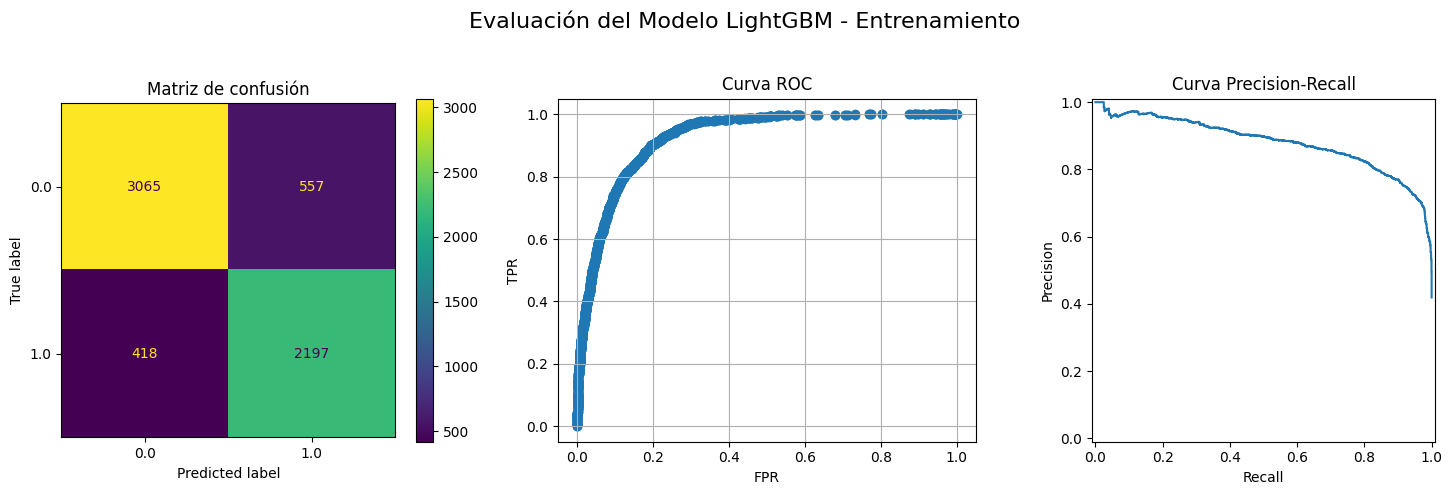

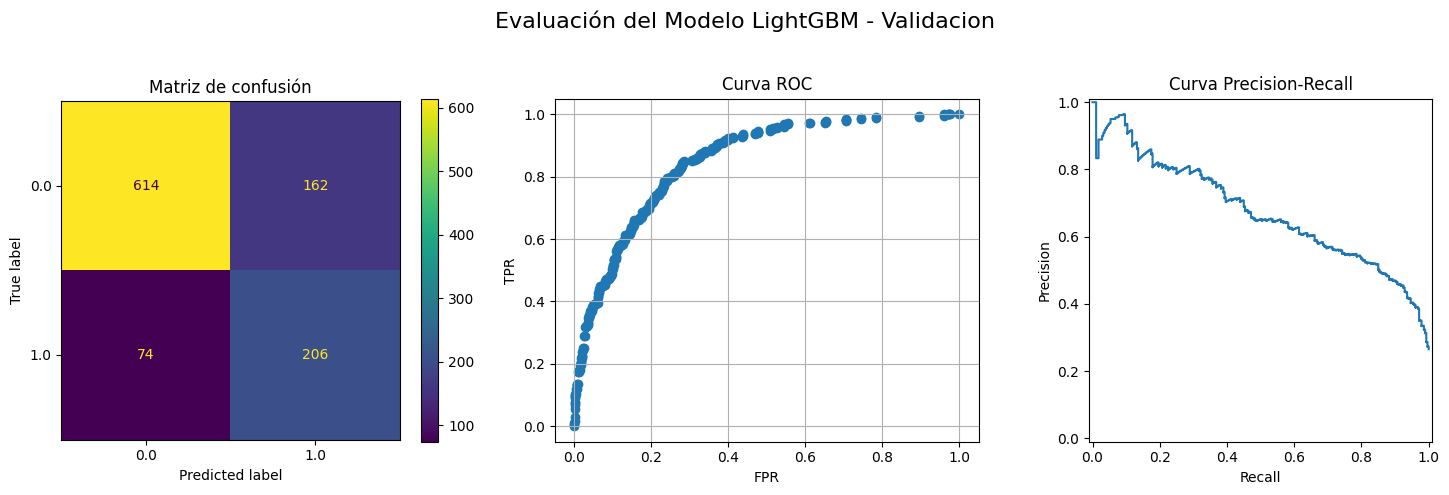

         ****


In [68]:
model_evaluation_meth(model_lgbm, 'LightGBM', df_train_ohe_notnull_scaled_up, df_valid_ohe_notnull_scaled,show_print=True, graph=True)

#### CatBoost

In [69]:
model_catb = catb.CatBoostClassifier(iterations=100,  
                                    learning_rate=0.05,
                                    depth=15,
                                    loss_function='Logloss',
                                    random_seed=ran,
                                    cat_features=categorical_variables,
                                    verbose=50,  
                                    early_stopping_rounds=10  
                                    )

In [70]:
df_train_scaled = numerical_scaler(df_train).fillna(0)
df_valid_scaled = numerical_scaler(df_valid).fillna(0)
df_train_up = upsampling_dataframe(df_train).fillna(0)
df_train_scaled_up = upsampling_dataframe(numerical_scaler(df_train)).fillna(0)

In [71]:
model_evaluation_meth(model_catb, 'Catboost', df_train_scaled_up, df_valid_scaled, show_print = True, graph=False)

0:	learn: 0.6826324	total: 1.16s	remaining: 1m 55s
50:	learn: 0.4379809	total: 32.3s	remaining: 31.1s
99:	learn: 0.3576017	total: 1m 2s	remaining: 0us

            Modelo: Catboost - Entrenamiento
            F1 score: 0.87
            ROC AUC score: 0.89
            Recall: 0.88
            Precision: 0.86

            Modelo: Catboost - Validacion
            F1 score: 0.63
            ROC AUC score: 0.76
            Recall: 0.70
            Precision: 0.58
         ****


In [72]:
model_evaluation_meth(model_catb, 'Catboost', df_train_scaled, df_valid_scaled, show_print = True, graph=False)

0:	learn: 0.6751728	total: 33.5ms	remaining: 3.31s
50:	learn: 0.4218786	total: 37.3s	remaining: 35.9s
99:	learn: 0.3511658	total: 1m 5s	remaining: 0us

            Modelo: Catboost - Entrenamiento
            F1 score: 0.72
            ROC AUC score: 0.80
            Recall: 0.64
            Precision: 0.83

            Modelo: Catboost - Validacion
            F1 score: 0.60
            ROC AUC score: 0.72
            Recall: 0.51
            Precision: 0.72
         ****


0:	learn: 0.6826324	total: 806ms	remaining: 1m 19s
50:	learn: 0.4379809	total: 25.1s	remaining: 24.1s
99:	learn: 0.3576017	total: 44.8s	remaining: 0us

            Modelo: Catboost - Entrenamiento
            F1 score: 0.87
            ROC AUC score: 0.89
            Recall: 0.88
            Precision: 0.86

            Modelo: Catboost - Validacion
            F1 score: 0.63
            ROC AUC score: 0.76
            Recall: 0.70
            Precision: 0.58


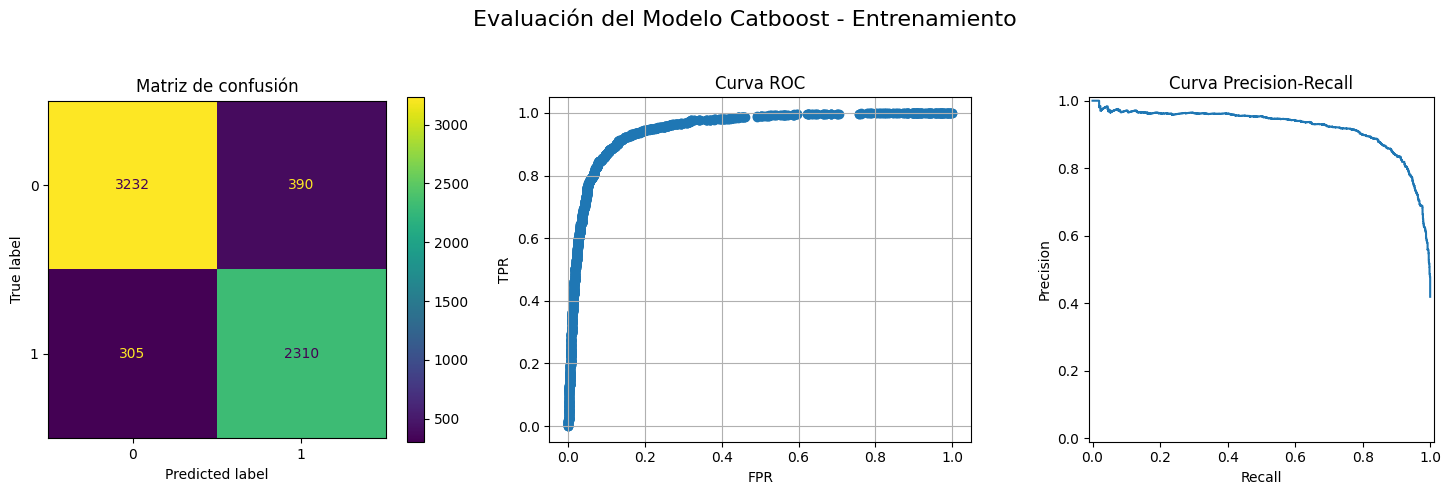

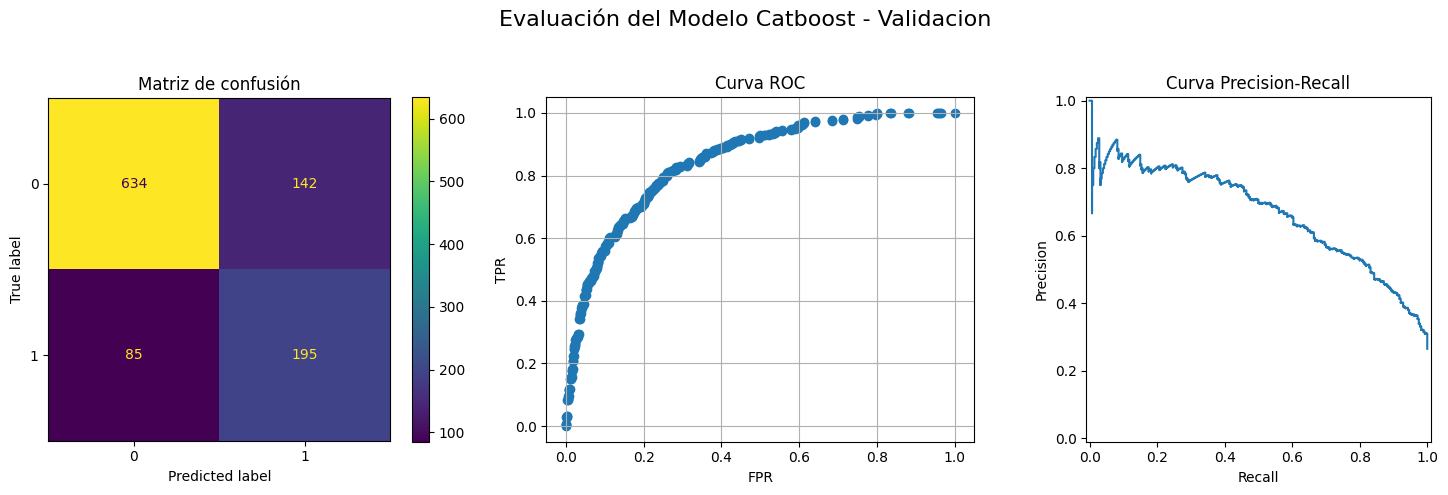

         ****


In [73]:
model_evaluation_meth(model_catb, 'Catboost', df_train_up, df_valid, show_print = True, graph=True)

- Realizar sobremuestreo mejora el desempeño del entrenamiento del modelo.
- Los modelos presentaron resultados similares, incluso el modelo de referencia que es la regresión logística presenta resultados generales iguales a los demás.
- De los modelos presentados XGBoost y LightGBM presentar los valores más altos para las métricas de F1 score y ROCAUC score. En este caso buscamos identificar la mayor cantidad de usuarios que puedan desertar, por lo cual la métrica de F1 score cobra importancia ya que queremos optimizar igualmente el recall, variable intrinseca en la medida. 
- De igual manera se realizaron pruebas con varias series de datasets realizando modificaciones y viendo el comportamiento de los parámetros. Los dataframes que tienen upsampling mejoran el desempeño del modelo en los datos de validación, mientras que realizar escalado no genera de las características numéricas no genera un cambio significativo, para el modelo XGBoost. 
- Se procede a realizar un optimización del modelo. 

## Optimización

#### Selección de parámetros

In [74]:
model_xgboost_selection = XGBClassifier(objective='binary:logistic',
                              eval_metric='auc',
                                learning_rate = 0.01, 
                                max_depth=8, 
                                subsample=0.8,
                                colsample_bytree=0.8,
                                n_estimators=100,
                                alpha=0,
                                random_state=ran)
model_evaluation_meth(model_xgboost_selection, 
                      'XGBoost', 
                      df_train_ord_encoded_notnull_up, 
                      df_valid_ord_encoded_notnull,
                      show_print=True)


            Modelo: XGBoost - Entrenamiento
            F1 score: 0.82
            ROC AUC score: 0.84
            Recall: 0.81
            Precision: 0.82

            Modelo: XGBoost - Validacion
            F1 score: 0.63
            ROC AUC score: 0.76
            Recall: 0.69
            Precision: 0.58
         ****


In [75]:
selection_importances_xg = pd.DataFrame({'feature_name_x': model_xgboost_selection.feature_names_in_,
                                    'importance_value_x':model_xgboost_selection.feature_importances_}).sort_values(by='importance_value_x', ascending=False)
selection_importances_xg

,feature_name_x,importance_value_x
14,type,0.607793
16,internetservice,0.121287
3,months,0.034829
1,monthlycharges,0.024470
8,streamingtv,0.021121
2,totalcharges,0.020989
9,streamingmovies,0.018617
0,paperlessbilling,0.017351
4,onlinesecurity,0.015816
7,techsupport,0.015322


In [76]:
model_xgboost_selection = XGBClassifier(objective='binary:logistic',
                              eval_metric='map',
                                learning_rate = 0.05, 
                                max_depth=5, 
                                subsample=0.8,
                                colsample_bytree=0.8,
                                n_estimators=100,
                                alpha=3,
                                random_state=ran,
)
columns_to_drop = [
  'seniorcitizen',
  'dependents',
  'deviceprotection',
  'partner',
  'gender']
model_evaluation_meth(model_xgboost_selection, 
                      'XGBoost', 
                      df_train_ord_encoded_notnull_up, 
                      df_valid_ord_encoded_notnull,
                      show_print=True)


            Modelo: XGBoost - Entrenamiento
            F1 score: 0.78
            ROC AUC score: 0.81
            Recall: 0.80
            Precision: 0.76

            Modelo: XGBoost - Validacion
            F1 score: 0.65
            ROC AUC score: 0.78
            Recall: 0.78
            Precision: 0.56
         ****


- Se recortan los parámetros a los 12 con mayor importancia para aligerar el modelo y como se observa el valor de ROCAUC score no disminuye para los datos de validación 0,77 y disminuye la sobreoptimización con respecto a los datos de entrenamiento. 

#### GridSearch

In [77]:
model_xgb_gridsearch =XGBClassifier(objective='binary:logistic',
                                eval_metric='auc',
                                alpha=3,
                                random_state=ran)
param_grid = {
    "n_estimators": [80,90,100],  
    "learning_rate": [0.005, 0.01,],  
    "max_depth": [7, 8], 
    "subsample": [0.8, 0.9],
    "colsample_bytree": [0.8,0.9]
}
grid_search = GridSearchCV(
    estimator=model_xgb_gridsearch,
    param_grid=param_grid,
    scoring="roc_auc",  
    cv=3,  
    verbose=3  
)

In [78]:
df_train_valid = pd.concat([df_train_ord_encoded_notnull_up, df_valid_ord_encoded_notnull], axis=0).drop(columns_to_drop, axis=1)
features_search, target_search = features_target_split(df_train_valid)

In [79]:
grid_search.fit(features_search, target_search)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.005, max_depth=7, n_estimators=80, subsample=0.8;, score=0.851 total time=   0.0s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.005, max_depth=7, n_estimators=80, subsample=0.8;, score=0.847 total time=   0.0s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.005, max_depth=7, n_estimators=80, subsample=0.8;, score=0.857 total time=   0.0s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.005, max_depth=7, n_estimators=80, subsample=0.9;, score=0.851 total time=   0.0s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.005, max_depth=7, n_estimators=80, subsample=0.9;, score=0.848 total time=   0.0s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.005, max_depth=7, n_estimators=80, subsample=0.9;, score=0.858 total time=   0.0s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.005, max_depth=7, n_estimators=90, subsample=0.8;, score=0.851 total time=   0.0s
[CV 2/3

GridSearchCV(cv=3,
             estimator=XGBClassifier(alpha=3, base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_r...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.005, 0.01], 'max_depth': [7, 8],
                         'n_estimators': [80, 90, 100],
                         'subsample': [0.8, 0.9]},
             scoring='roc_auc', verbose=3)

In [80]:
print(f"Mejores parámetros: {grid_search.best_params_}")

Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.9}


In [81]:
best_xgboost = grid_search.best_estimator_


            Modelo: XGBoost - Entrenamiento
            F1 score: 0.77
            ROC AUC score: 0.80
            Recall: 0.76
            Precision: 0.78

            Modelo: XGBoost - Validacion
            F1 score: 0.63
            ROC AUC score: 0.76
            Recall: 0.70
            Precision: 0.58


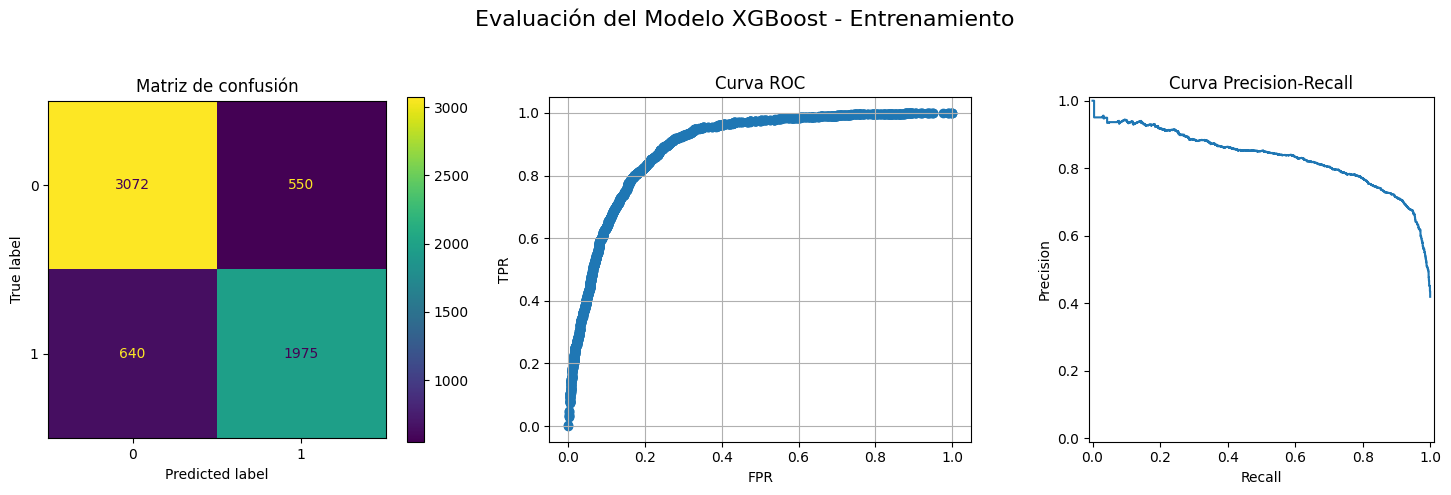

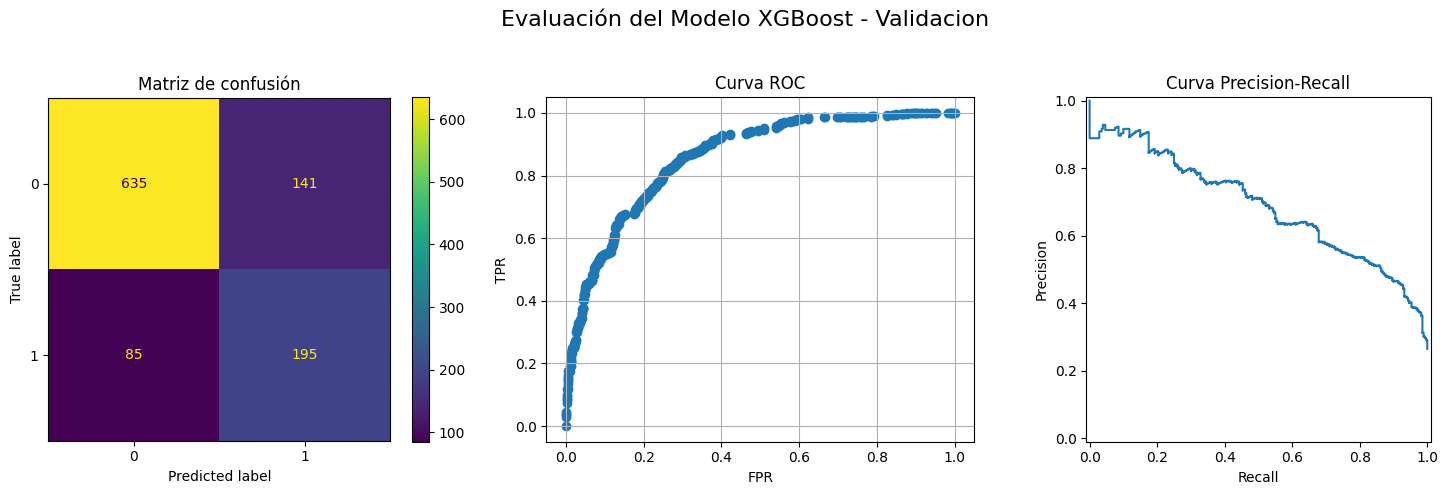

         ****


In [82]:
results_gridsearch = model_evaluation_meth(best_xgboost, 
                      'XGBoost', 
                      df_train_ord_encoded_notnull_up.drop(columns_to_drop, axis=1), 
                      df_valid_ord_encoded_notnull.drop(columns_to_drop, axis=1), 
                      show_print = True, graph=True)

In [83]:
model_lgbm_gridsearch =lgbm.LGBMClassifier(
                                 random_state=ran)
param_grid_lgbm= {
    "n_estimators": [80,90,100],  
    "learning_rate": [0.005, 0.01,],  
    "max_depth": [7, 8], 
    "subsample": [0.8, 0.9],
    "colsample_bytree": [0.8,0.9]
}
grid_search_lgbm = GridSearchCV(
    estimator=model_lgbm_gridsearch,
    param_grid=param_grid_lgbm,
    scoring="roc_auc",  
    cv=3,  
    verbose=3  
)
df_train_valid = pd.concat([df_train_ord_encoded_notnull_up, df_valid_ord_encoded_notnull], axis=0).drop(columns_to_drop, axis=1)
features_search, target_search = features_target_split(df_train_valid)
grid_search_lgbm.fit(features_search, target_search)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[LightGBM] [Info] Number of positive: 1930, number of negative: 2932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 4862, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.396956 -> initscore=-0.418165
[LightGBM] [Info] Start training from score -0.418165
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.005, max_depth=7, n_estimators=80, subsample=0.8;, score=0.848 total time=   0.0s
[LightGBM] [Info] Number of positive: 1930, number of negative: 2932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=12345),
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.005, 0.01], 'max_depth': [7, 8],
                         'n_estimators': [80, 90, 100],
                         'subsample': [0.8, 0.9]},
             scoring='roc_auc', verbose=3)

Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.8}
[LightGBM] [Info] Number of positive: 2615, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 6237, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.419272 -> initscore=-0.325762
[LightGBM] [Info] Start training from score -0.325762

            Modelo: LGBM - Entrenamiento
            F1 score: 0.75
            ROC AUC score: 0.79
            Recall: 0.74
            Precision: 0.76

            Modelo: LGBM - Validacion
            F1 score: 0.64
            ROC AUC score: 0.76
            Recall: 0.72
            Precision: 0.57


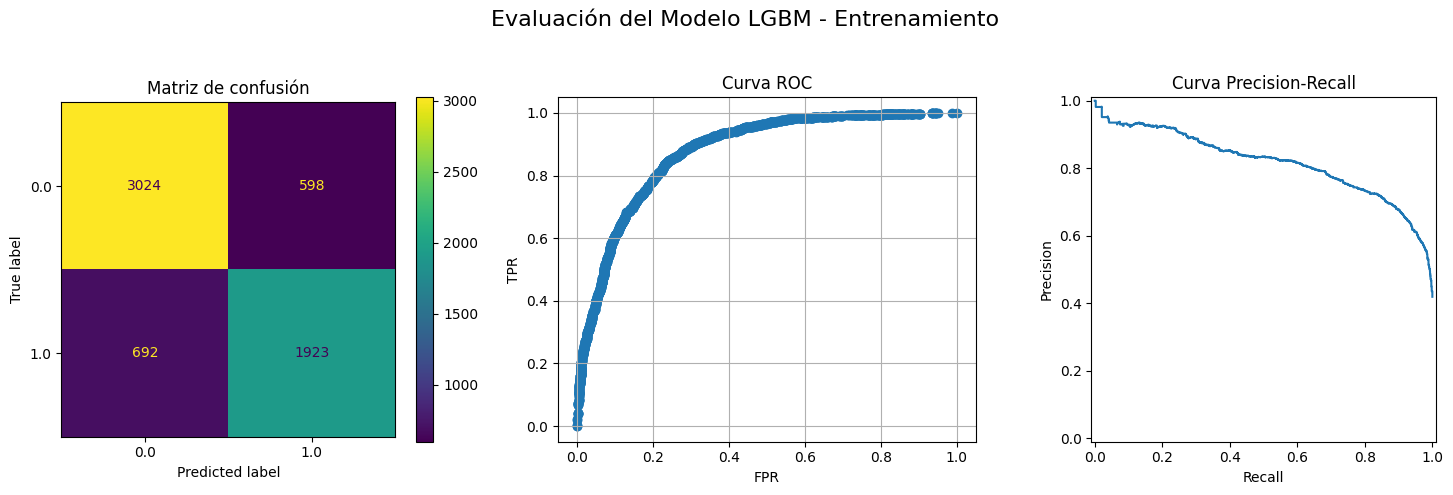

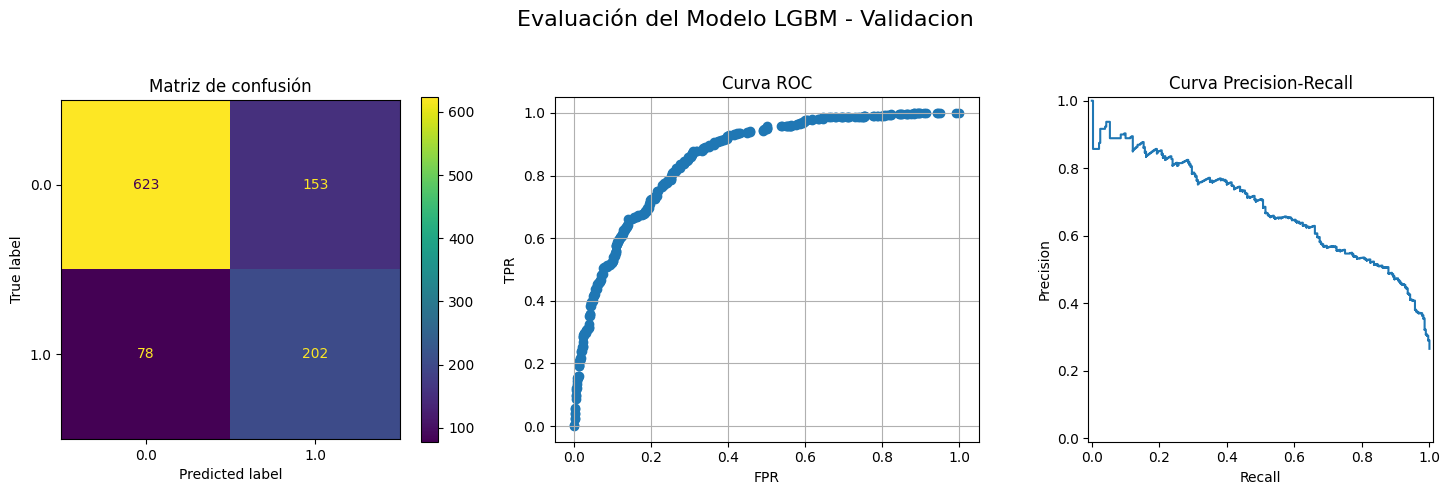

         ****


In [84]:
print(f"Mejores parámetros: {grid_search_lgbm.best_params_}")
best_lgbm = grid_search_lgbm.best_estimator_
results_gridsearch_lgbm = model_evaluation_meth(best_lgbm, 
                      'LGBM', 
                      df_train_ord_encoded_notnull_up.drop(columns_to_drop, axis=1), 
                      df_valid_ord_encoded_notnull.drop(columns_to_drop, axis=1), 
                      show_print = True, graph=True)

- Después de realizar selección de parámetros y optmizar los modelos LightGBM y XGBoost, se observa que los modelos siguen comportandose muy similares y no existe una mejora en las métricas de respuesta, respecto a lo obtenido previamente, manteniendo un F1 score de 0.63 y un ROC AUC score de 0.76.

### Prueba con datos de test

- Para la medición con los datos de test se selecciona el dataset que mostró los mejores resultados, codificación ordinal y el modelo entrenado con sobremuestreo.

In [85]:
model_xgboost_optimized = XGBClassifier(objective='binary:logistic',
                                eval_metric = 'aucpr',
                                learning_rate = 0.05, 
                                max_depth=5, 
                                subsample=0.8,
                                colsample_bytree=0.8,
                                n_estimators=100,
                                alpha=3,
                                random_state=ran,
)

model_evaluation_meth(model_xgboost_optimized, 
                      'XGBoost', 
                      df_train_ord_encoded_notnull_up.drop(columns_to_drop, axis=1), 
                      df_valid_ord_encoded_notnull.drop(columns_to_drop, axis=1),
                      show_print=True)


            Modelo: XGBoost - Entrenamiento
            F1 score: 0.77
            ROC AUC score: 0.80
            Recall: 0.79
            Precision: 0.76

            Modelo: XGBoost - Validacion
            F1 score: 0.63
            ROC AUC score: 0.76
            Recall: 0.74
            Precision: 0.56
         ****


In [86]:
df_test_final = ordinal_encoder(df_test).fillna(0).drop(columns_to_drop, axis=1)
features_test, target_test = features_target_split(df_test_final)
predictions_test = model_xgboost_optimized.predict(features_test)
predictions_proba_test = model_xgboost_optimized.predict_proba(features_test)

In [87]:
model_xgboost_results = metrics_results(model_xgboost_optimized, target_test, predictions_test, predictions_proba_test, show_print =True)


            Modelo: XGBClassifier(alpha=3, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)
            F1 score: 0.64
            ROC AUC score: 0.76
            Recall: 0.71
            Precision: 0.59


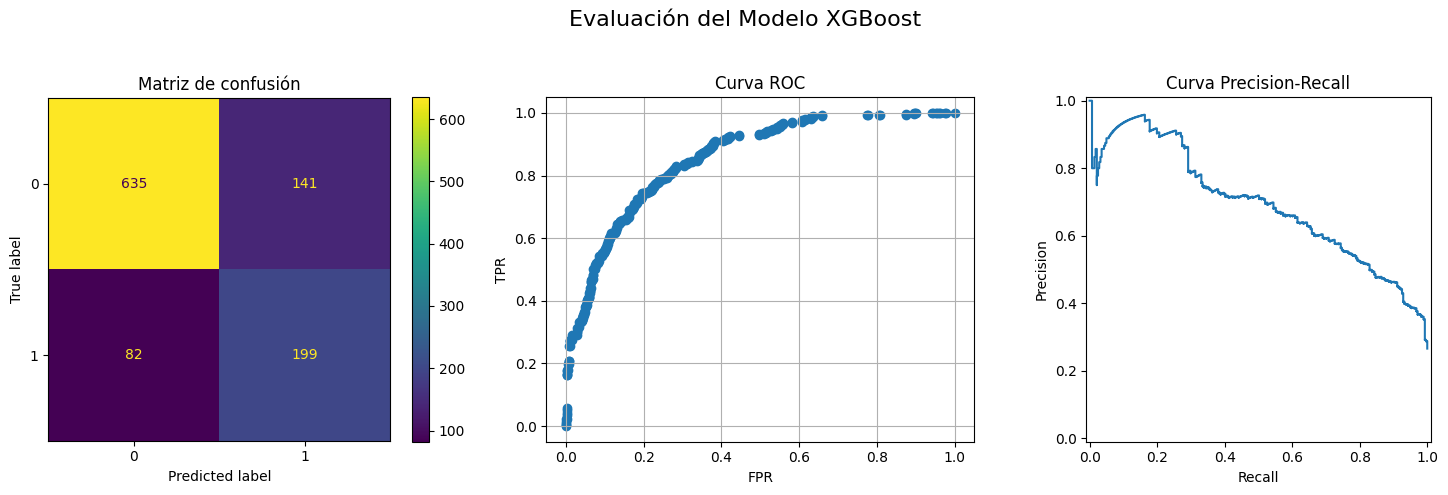

In [88]:
metrics_graphs(model_xgboost_optimized, 'XGBoost', model_xgboost_results)

### Prueba con bootstrap sin slección de datasets estratificados.

- Esta es una prueba adicional para verificar que el modelo no sea dependiente de la estratificación de la variable objetivo, para ello se hace una prueba de bootstrap con distintos random state y sin estratificar la variable objetivo.
- Se selecciona igualmente el dataset que dió los mejores resultados en el entrenamiento de los modelos que fue realizando sobremuestreo y con codificación ordinal. 

In [89]:
def boostrap_random_state_evaluation(model,df_to_bootstrap, model_name = 'regresion'):
    np.random.seed(random_seed)
    random_list = [np.random.randint(0,100000) for _ in range(10)]
    
    for num in random_list:
        df_train, df_pass = train_test_split(df_to_bootstrap, test_size=0.30, random_state=num)
        df_valid, df_test = train_test_split(df_pass, test_size=0.5, random_state=num)
        df_train = upsampling_dataframe(df_train)
        list_df = [df_train, df_valid, df_test]
        list_df_mod = []
        
        for data in list_df:
            df_new = fix_df_traintest(data)
            df_new = ordinal_encoder(df_new).fillna(0).drop(columns_to_drop, axis=1)
            list_df_mod.append(df_new)
        
        print(f'Prueba con número rándom state {num}')
        
        results = []
        for data in list_df_mod:
            features, target = features_target_split(data)
            predictions = model.predict(features)
            predictions_proba = model.predict_proba(features)
            results.append(format_simple_results(metrics_results(model_name, target, predictions, predictions_proba, show_print =False)))
        
        results = pd.DataFrame(results, columns=['f1_score', 'auc_roc'], index=['train', 'valid', 'test'])
        print(results)
        print(f'F1 score promedio: {results['f1_score'].mean():.2f}')
        print(f'AUC-ROC promedio: {results['auc_roc'].mean():.2f}')
        print('------->>>>><<<<<<----------')

In [90]:
boostrap_random_state_evaluation(model_xgboost_optimized, df_merge_m, 'XGBoost')

Prueba con número rándom state 15795
       f1_score  auc_roc
train      0.75     0.78
valid      0.67     0.79
test       0.69     0.81
F1 score promedio: 0.70
AUC-ROC promedio: 0.79
------->>>>><<<<<<----------
Prueba con número rándom state 860
       f1_score  auc_roc
train      0.75     0.78
valid      0.66     0.80
test       0.71     0.81
F1 score promedio: 0.71
AUC-ROC promedio: 0.80
------->>>>><<<<<<----------
Prueba con número rándom state 76820
       f1_score  auc_roc
train      0.76     0.79
valid      0.67     0.78
test       0.64     0.78
F1 score promedio: 0.69
AUC-ROC promedio: 0.78
------->>>>><<<<<<----------
Prueba con número rándom state 54886
       f1_score  auc_roc
train      0.75     0.79
valid      0.68     0.79
test       0.68     0.78
F1 score promedio: 0.70
AUC-ROC promedio: 0.79
------->>>>><<<<<<----------
Prueba con número rándom state 6265
       f1_score  auc_roc
train      0.75     0.78
valid      0.66     0.81
test       0.66     0.79
F1 score prome

In [91]:
joblib.dump(model_xgboost_optimized, 'pretrained_models/xgb_model_trained.pkl')

['pretrained_models/xgb_model_trained.pkl']

- Como se puede observar el modelo es estable al probarse con distintas combinaciones a la hora de realizar la separación de los datos de entrenamiento, validación y prueba, dando como resultado un AUC-ROC promedio entre 0.78 y 0.80.

### Estudio de la curva Lift

In [92]:
df_merge_m_copy = df_merge_m.copy()
df_to_lift = fix_df_traintest(df_merge_m_copy)
df_to_lift = ordinal_encoder(df_to_lift).fillna(0).drop(columns_to_drop, axis=1)
features_lift, target_lift = features_target_split(df_to_lift)

In [93]:
predict_proba_lift = model_xgboost_optimized.predict_proba(features_lift)[:, 1]  
df_lift = pd.DataFrame({'true': target_lift, 'proba': predict_proba_lift}).sort_values(by='proba', ascending=False)
df_lift['decil'] = pd.qcut(df_lift['proba'], 10, labels=False)
lift_data_real = df_lift.groupby('decil')['true'].mean()
baseline = df_lift['true'].mean()
lift_score = lift_data_real / baseline

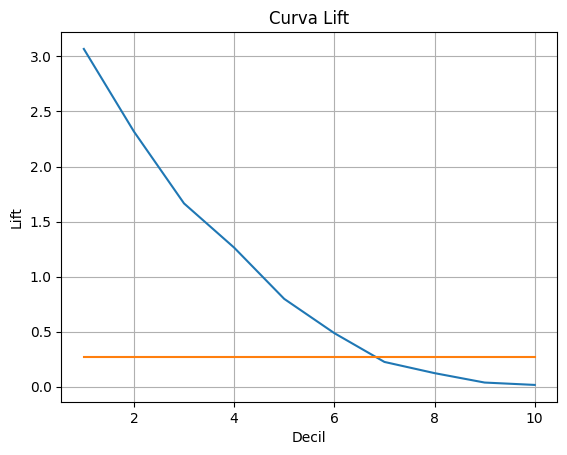

In [94]:
plt.plot(range(1, 11), lift_score[::-1])  
plt.plot(range(1,11), np.full(lift_score.shape, baseline) )
plt.xlabel('Decil')
plt.ylabel('Lift')
plt.title('Curva Lift')
plt.grid()
plt.show()


In [95]:
proba_lift_1 = df_lift[df_lift['decil']==9]['true'].sum() / len(df_lift[df_lift['decil']==9])*100
print(f'La probabilidad de escoger un cliente en el primer decil que vaya a dejar el servicio es de {proba_lift_1:.0f}% ')

La probabilidad de escoger un cliente en el primer decil que vaya a dejar el servicio es de 81% 


## Pipeline de preprocesamiento

In [97]:
# Se presupone que los datos nuevos que se van a ingresar son datos netamente para realizar predicciones, por lo que la columna enddate o chrun no existe

dict_yes_no = {'Yes' : 1,'No' : 0 }
yes_no_columns = ['paperlessbilling', 'onlinesecurity', 'onlinebackup','deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'partner', 'dependents', 'multiplelines']
categorical_variables = ['type', 'paymentmethod', 'internetservice', 'gender']
columns_to_drop = ['seniorcitizen','dependents','deviceprotection','partner','gender']

def merge_dataframes(df_contract_m, df_internet_m, df_personal_m, df_phone_m):
    df_merge = df_contract_m.merge(df_internet_m, on='customerid', how='outer')\
                            .merge(df_personal_m, on='customerid', how='outer')\
                            .merge(df_phone_m, on='customerid', how='outer')
    return df_merge

def column_name_to_lowercase(df):
    return df.columns.str.lower()

def format_dataframe(df):
    df['begindate'] = pd.to_datetime(df['begindate'], format='%Y-%m-%d')
    df['totalcharges'] = df['totalcharges'].replace(' ', 0).astype(float)
    df['months'] = round(df['totalcharges']/df['monthlycharges'],0)
    df['internetservice'] = df['internetservice'].fillna('Not Hired')
    for col in yes_no_columns:
        df[col] = df[col].map(dict_yes_no)
    return df

def fix_df_traintest(df):
    df = df.reset_index(drop=True).drop(['customerid', 'begindate'], axis=1)
    return df

def ordinal_encoder(df):
    ordinal_encoder_pretrained = joblib.load('pretrained_models/ordinal_encoder_with_columns.pkl')
    var_encoded = pd.DataFrame(ordinal_encoder_pretrained.transform(df[categorical_variables]), 
                                columns=categorical_variables)
    return pd.concat([df.drop(categorical_variables, axis=1), var_encoded], axis=1)

def pipeline_procesing(df_contract_m, df_internet_m, df_personal_m, df_phone_m):
    df_merged = merge_dataframes(df_contract_m, df_internet_m, df_personal_m, df_phone_m)
    df_columns_lower = column_name_to_lowercase(df_merged)
    df_formated = format_dataframe(df_columns_lower)
    df_clean = fix_df_traintest(df_formated)
    df_encoded = ordinal_encoder(df_clean).fillna(0).drop(columns_to_drop, axis=1)
    
    model_xgb = joblib.load('pretrained_models/xgb_model_trained.pkl')
    predictions_model = model_xgb.predict(df_encoded)
    return predictions_model

## INFORME

1. ETAPAS DEL PROYECTO

El proyecto se dividió en 4 etapas: Exploración, Preprocesamiento, Entrenamiento de los modelos y Optimización. A continuación se describé el objetivo de cada una de estas etapas y los principales hallazgos en cada etapa.


 - Exploración:


La principal idea era conocer los datos y su comportamiento, si se observan datos nulos, duplicados, atipicos o cualquier anomalía que debiera corregirse. Aquí debieron realizarse algunas gráficas de barras e histogramas para observar el comportamiento de los datos.

Se encontró que la mayoría de los datos eran datos binarios (Yes, No) o variables categóricas y que solo los valores de pago eran variables numéricas continuas. Algunas variables como las fechas y el cargo total tenian un tipo de dato que no correspondía y debía corregirse.
Adicionalmente se observó que variables objetivo EndDate se encontraba desbalanceada en una proporción de 1 a 4.

En cuanto a la distribución de los datos algunas variables categóricas como streamingTV y streamingMovies estaban balanceadas en cantidad y proporción de clientes que abandonaban la plataforma, por lo que podría preveerse que habrían variables que no serían necesarias para el entrenamiento de los modelos.

Finalmente se observó que los datos de pago daban información importante sobre si el cliente dejaba la plataforma, ya que la mayoría de los clientes que abandonaron tenían un periodo largo desde que iniciaron el uso del servicio y, adicionalmente, aquellos que pagan más podrían dejar más facilmente la plataforma.


 - Preprocesamiento:
  

El objetivo de esta etapa es arreglar el formato de los datos y crear distintos dataframes que permitieran entrenar el modelo desde distintos angulos para encontrar la mejor opción.

Una vez observados los datos era necesario corregir algunos errores dentro de los dataframe para poder trabajar. Primero se debían juntar los dataframes para facilitar el procesamiento, para ello se usó la variable customerID como referencia. Adicionalemnte, se cambiaron los titulos de las columnas a minúsculas para estandarizarlos. Luego se cambiaron los columnas que tenían fechas a tipo datetime y las variables numéricas a float, mientras que las variables binarias con yes/no se cambiaron a 1/0.

Adicionalmente se creo la varibale Month que habla del tiempo en meses aproximadamente que un cliente ha usado el servicio de Telecom. Para esto se dividió el pago total entre el pago mensual.

La variable objetivo se transforma a 0 y 1, siendo 1 si dejo el servicio y 0 si aún lo usa. No se usan las fechas puesto que el problema solo especifica que el modelo debe predicir si el cliente abandona o no el servicio.

Luego de arreglar el tema de formato de los datos se procedió a separar el dataframe en entrenamiento, validación y prueba, usando una proporción de 70:15:15. Observando que solo se tenían 7043 datos, los cuales se consideraron pocos para entrenar el modelo, se decidió dejar una alta proporción para el entrenamiento. También, para garantizar una proporción constante de la varible objetivo entre los distintos dataframes se decide usar el parámetro stratify para hacer una estratificación de dicho parámetro.

Para crear distintos dataframes basados en las posibles opciones de entrenamiento de los modelos y su comportamiento. Para ello se empleó:
    - Escalamiento con el modulo standardScaler de skelearn, para llevar los datos de pago a números más bajos, que facilita el procesamiento de modelos lineales.
    - Codificación ordinal y One-Hot-Encoding para las variables categóricas y probar con los modelos de tipo árbol de decisión.

Posteriormente se llenaron los valores nulos con 0, ya que aquellas variables hablaban de que el usuario no adquirió el servicio.

Finalmente se adaptaron algunos dataframes usando sobremuestreo para compensar el desbalanceo de clases.

Los dataframes para entrenamiento fueron:
    -  Ordinal encoding / Sin Escalado / Sin Upsampling
    -  Ordinal encoding / Sin Escalado / Con Upsampling  
    -  Ordinal encoding / Con Escalado / Con Upsampling
    -  OHE / Sin Escalado / Sin Upsampling  
    -  OHE / Sin Escalado / Con Upsampling  
    -  OHE / Con Escalado / Con Upsampling 


 - Entrenamiento de los modelos:

  
En esta etapa se prueban distintos modelos de clasificación para encontrar esa variable objetivo.

Se crean algunas funciones que permitieran evaluar los modelos sin necesidad de repetir codigo. Adicionalmente, se emplearon las métricas de Recall, Precision, F1score y AUC-ROC para evaluar los modelos.

Los modelos evaluados fueron: Regresión Logistica, Random Forest, XGboost, LigthGBM y CatBoost. Se escogieron estos modelos porque son buenos tratando variables categóricas. La regresión logistica se uso como referencia.

La mayoría de los modelos tuvieron un desempeño similar mostrando un F1 score de 0.65 y un AUC-ROC de 0.77 en promedio. Por lo que se decantó en el uso y comparación posterios de los modelos LightGBM y XGBoost, que demostraron menor sobreoptimización entre los datos de entrenamiento y validación. Por otro lado, CatBoost tenía tiempos de compilación más largo que los anteriores.

Además, se observó que no había mucha diferencia entre realizar OHE y ordinal encoding en los resultados. Tampoco escalar los datos cambiaba en gran medida el resultado. Lo que si generaba un cambio apreciable era entrenar los modelos con sobremuestreo, esto mejoraba los resultados de los modelos entre un 15% y 20%.


 - Optimización


El objetivo de esta etapa era mejorar el desempeño de los modelos escogidos en la etapa anterior.

Para opimizar los modelos se empleo gridsearch de sklearn, sin embargo, no se observaron mejorar apreciables en los modelos y si se encontró sobreoptimización en los datos de entrenamiento, por lo que el módulo de gridsearch se tuvo que restringir bastante en sus parámetros. 

Por otro lado, se probó realizando una reducción de dimensionalidad en donde se encontro que variables como 'seniorcitizen', 'dependents', 'deviceprotection', 'partner' y 'gender' no aportaban información a los modelos, retirarlas producía los mismos resultados y reducía la dimensionalidad del problema. Se decidió escoger el modelo XGBoost por sobre LightGBM pues su desempeño en la optimización fue mejor, sin que se redujeran los parametros AUC-ROC y F1score.

Posteriomente, se realizaron predicciones sobre los datos de prueba para verificar el comportamiento del modelo xgboost encontrando que el modelo también era estable con datos que nunca hubiera visto. 

Finalmente, se hizo una prueba de bootstraping sobre el modelo xgboost para verificar que le modelo no dependiera de la estratificación de los datos realizada en la separación entrenamiento/prueba en etapas anteriores. Se generaron distintas particiones basadas en números aleatorios, encontrando que el modelo también es estable resultando en un AUC-ROC promedio entre 0.78 y 0.80.


 - Resultados finales


Se emplea un análisis de curva lift para verificar cuánto es mejor el modelo que una selección promedio. Se encuentra que escoger el 10% de las predicciones con mayor probabilidad de abandono, estimada por el modelo, genera 6 veces más predicciones positivas que hacer una selección al azar. 

Lo anterior demuestra la confiabilidad del modelo.

No se omitió ninguna etapa del plan inicial, todo lo planteado se desarolló.


2. DIFICULTADES

Los principales problemas se encontraron en al generalización de las funciones para entrenar los modelos. Modelos como catboost hacen su propia clasificación por lo que no se aplican todo el preprocesamiento para los otros modelos. 

Adicionalmente subir el desempeño del modelo fue complejo y requirió de crear la varibale Months y modificar los parámetros de los modelos, restringiendo el proceso de entrenamiento usando regulariazación y pasando por una etapa de prueba y error bastante larga. 

Por lo demás no hubo muchos problemas pues los datos se encontraban bastante limpios y tratarlos fue sencillo.


3. PASOS CLAVE

Desde mi punto de vista hubo 4 pasos que permitieron alcanzar los resultados del modelo.
    - Crear distintos dataframes que permitieran explorar el desempeño de los modelos desde distintos ángulos.
    - Lo anterior permitió observar como el realizar sobremuestreo sobre los datos de entrenamiento subía el desempeño del modelo en un 15% a 20%.
    - La creación de la variable 'Months', que aún que no muestra una comparación en el trabajo si permitió que el modelo se estabilizara y aumentar el valor de la variable AUC-ROC de valores de 0.72 en promedio a 0.77 en promedio.
    - Finalmente, establecer funciones que permitieran iterar y probar los modelos de manera sencilla sin necesidad de adicionar código que relentizara la tarea.

4. MODELO FINAL Y CALIDAD DEL MODELO

El modelo final empleado es un XGBoost con los parámetros que se muestran a continuación:

XGBClassifier(objective='binary:logistic',
            eval_metric = 'aucpr',
            learning_rate = 0.05, 
            max_depth=5, 
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=100,
            alpha=3,
            random_state=ran,)

El modelo alcanza parámetros de predicción de:

F1 score : 0.69 - 0.71
AUC-ROC: 0.78 -0.80

Puesto que este tipo de modelos se emplea para escoger clientes que pueden abandonar el servicio de la compañía y a los que se les va a ofrecer ofertas, solo se puede escoger una pequeña proporción de clientes. De escoger que se enviaría una promoción al 10% de los clientes más probables de abandonar la compañía, predichos por el modelo, se tendrá una certeza que alrededor del 81% van a dejar la compañía en el futuro y se podrán retener. 